In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from df_utils import get_companies_list, get_X_y
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, \
                            precision_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest

#### Load the dataframe and companies with not too many nans

In [18]:
df, companies = get_companies_list(2)
# learner history parameters
nhist = 10
nfut = 2
totHist = int(3*365 - nhist)

comp_dict = {}
for i, comp in enumerate(companies):
    comp_dict[comp] = get_X_y(df, comp, nfut, nhist, totHist)

#### Drop some columns:

In [19]:
X_orig, y, ysim = comp_dict[comp]
print(X_orig.columns.values)
print(y.columns.values)
print(ysim.columns.values)

include = ['c_oend_%', 'c_slow_%', 'c_shigh_%', 'change_Me', 'offer_sell_', 'offer_buy_'] #['c_shigh_', 'c_slow_', 'offer_sell_', 'offer_buy_', 'sales_low_', 'sales_high_']
cols_keep = [col for col in X_orig.columns if col[:-4] in include] 
y_cols = ['offer_end_change', 'sale_low_change', 'sale_high_change']

['offer_end_-01' 'offer_end_-02' 'offer_end_-03' 'offer_end_-04'
 'offer_end_-05' 'offer_end_-06' 'offer_end_-07' 'offer_end_-08'
 'offer_end_-09' 'offer_end_-10' 'offer_buy_-01' 'offer_buy_-02'
 'offer_buy_-03' 'offer_buy_-04' 'offer_buy_-05' 'offer_buy_-06'
 'offer_buy_-07' 'offer_buy_-08' 'offer_buy_-09' 'offer_buy_-10'
 'offer_sell_-01' 'offer_sell_-02' 'offer_sell_-03' 'offer_sell_-04'
 'offer_sell_-05' 'offer_sell_-06' 'offer_sell_-07' 'offer_sell_-08'
 'offer_sell_-09' 'offer_sell_-10' 'sales_low_-01' 'sales_low_-02'
 'sales_low_-03' 'sales_low_-04' 'sales_low_-05' 'sales_low_-06'
 'sales_low_-07' 'sales_low_-08' 'sales_low_-09' 'sales_low_-10'
 'sales_high_-01' 'sales_high_-02' 'sales_high_-03' 'sales_high_-04'
 'sales_high_-05' 'sales_high_-06' 'sales_high_-07' 'sales_high_-08'
 'sales_high_-09' 'sales_high_-10' 'change_Me_-01' 'change_Me_-02'
 'change_Me_-03' 'change_Me_-04' 'change_Me_-05' 'change_Me_-06'
 'change_Me_-07' 'change_Me_-08' 'change_Me_-09' 'change_Me_-10'
 'c_s

### Plot pictures:

In [4]:
def plot_sim(comp, ysim, ndays, *args):
    
    
    plt.figure(figsize = (12,6))
    x = pd.to_datetime(ysim.index, format = '%d.%m.%Y')[:ndays]
    yl = ysim['sales_low_000'].values[:ndays]
    yh = ysim['sales_high_000'].values[:ndays]
    #y = ysim['offer_end_prev'].values[:ndays]
    
    #plt.plot_date(x,y, linestyle = '-', marker = None)
    plt.fill_between(x,yl,yh, linestyle = '-')
    plt.ylabel('Sales lowest to highest filled')
    #[plt.gca().axvline(xi, alpha = .1) for xi in x]
    
    if len(args) == 3:
        pred, truth, col = [arg[:ndays] for arg in args]
        
        correct = pred & truth
        fp = pred & np.logical_not(truth)
        
        plt.scatter(x[correct], yh[correct], s = 40, alpha = .7, 
                    c = 'green', label = col + ' correct')
        plt.scatter(x[truth], yh[truth], s = 20, c = 'red', alpha = .2,
                    label = col + ' true')
        
    else:    
        plt.twinx()
        y2 = ysim['offer_end_change']*100
        plt.plot_date(x,y2, linestyle = '-', marker = None, color = 'red')
        plt.ylabel('Offer end percentage change')
    
    plt.legend(frameon = False)
    plt.title(comp, fontsize = 14)
    plt.show()
   

### Make estimator pipe

In [20]:
pipe_rf = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                    ('var', VarianceThreshold()),
                    ('sel', SelectKBest()),
                    ('rf', RandomForestClassifier())]) 

params_rf = [{'sel__k': np.arange(40,100,10),
              'rf__max_features': np.arange(5,30,5),
              'rf__max_depth': [5,10,20],
              'rf__n_estimators': [20,50,100]}]

pipe_gbm = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                     ('var', VarianceThreshold()),
                     ('sel', SelectKBest()),
                     ('gbm', GradientBoostingClassifier())]) 

params_gbm = [{'sel__k': np.arange(10,50,10),
               'gbm__learning_rate': np.arange(.05,.3, .05),
               'gbm__max_depth': [3,5,10],
               'gbm__n_estimators': np.arange(50, 400, 50),
               'gbm__min_samples_leaf':[1,5,10,20]}]


def get_pipe(key):
    if key == 'rf':
        return pipe_rf, params_rf
    elif key == 'gbm':
        return pipe_gbm, params_gbm


### Make custom fit for each company:

In [10]:
def comp_estimator(comp, y, threshold, pipe, params, ntest = 50, metric = 'roc_auc'):
    
    splitter = StratifiedKFold(n_splits = 3, shuffle = True) #, random_state = 0)
    X,_,ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = threshold < y
    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    Xy = [X_train, X_test, y_train, y_test, ysim, y_bin]
    
    
    grid = GridSearchCV(pipe, params, scoring = metric, n_jobs = 5, 
                        cv = splitter, verbose = 1)
    grid.fit(X_train, y_train)
    
    return Xy, grid.best_estimator_, grid.best_params_, grid.best_score_


def get_scores(y_pred_train, y_pred_test, y_pred_train_p, 
               y_pred_test_p, y_train, y_test, show_report = False):
    try:
        roc_auc_test = roc_auc_score(y_test, y_pred_test_p)
    except ValueError as e:
        print(e)
        roc_auc_test = -1
    
    precision_test = precision_score(y_test, y_pred_test)
    
    if show_report:
        print('Train set classification')
        print(classification_report(y_train, y_pred_train, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_train, y_pred_train))
        print('Train roc_auc = {:.3f}'.format(roc_auc_score(y_train, y_pred_train_p)))
        print('\nTest set classification')
        print(classification_report(y_test, y_pred_test, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_test, y_pred_test))
        print('Test roc_auc = {:.3f}\n'.format(roc_auc_test))
    
    return roc_auc_test, precision_test

def get_prediction(Xy, estimator, show_report = False):
    
    X_train, X_test, y_train, y_test = Xy[:4]
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    y_pred_train_p = estimator.predict_proba(X_train)[:,1]
    y_pred_test_p = estimator.predict_proba(X_test)[:,1]
    
    
    return y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p


### Feed the pipe to fit for each company and collect the results

In [7]:
def fit_and_report(companies, key = 'rf', ntest = 100, show = False):
    
    thres = {'offer_end_change':.0, 
             'sale_low_change+1':.0,
             'sale_low_change':.0,
             'sale_high_change':.0}
    
    pipe, params = get_pipe(key)
    
    try:
        results_dict = np.load('opm_params_{}.npy'.format(key)).item()        
    except FileNotFoundError:
        results_dict = {}
    
    for comp in companies:
        y = comp_dict[comp][1]
        for col in y.columns.values:
            try:
                results_dict[comp][col]
            except KeyError:
                
                
                print(comp, ' ', col)

                X,_,ysim = comp_dict[comp]
                X = X[cols_keep]

                Xy, estimator_r, params_opm_r, score_r \
                    = comp_estimator(comp, y[col].values,
                                     thres[col], pipe, params,
                                     ntest = ntest,
                                     metric = 'roc_auc')

                y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p \
                    = get_prediction(Xy, estimator_r)

                roc_auc, precision = get_scores(y_pred_train, 
                                                y_pred_test, 
                                                y_pred_train_p, 
                                                y_pred_test_p, 
                                                Xy[2], Xy[3], 
                                                show_report = show)

                if show:
                    print(params_opm_r)
                    y_pred_tot = np.concatenate((y_pred_test, 
                                                 y_pred_train))
                    plot_sim(comp, Xy[4], ntest*4, y_pred_tot, 
                             Xy[5], col)


                col_dict = {col: {'roc_auc':roc_auc, 
                                  'precision':precision,
                                  'threshold':thres[col],
                                  'opm_params':params_opm_r}}
                try:
                    results_dict[comp].update(col_dict)
                except KeyError:
                    results_dict[comp] = col_dict
                 
                np.save('opm_params_{}'.format(key), results_dict)
    return results_dict


    

['Affecto', 'Ahlstrom-Munksjö', 'Aktia Pankki A', 'Alma Media', 'Amer Sports A', 'Apetit', 'Aspo', 'Atria A', 'Basware', 'Biohit B', 'Bittium', 'CapMan', 'Cargotec', 'Caverion', 'Citycon', 'Cramo', 'Digia', 'Elisa', 'F-Secure', 'Finnair', 'Fiskars', 'Fortum', 'Glaston', 'HKScan A', 'Huhtamäki', 'Kemira', 'Kesko A', 'Kesko B', 'Kone', 'Konecranes', 'Lassila & Tikanoja', 'Lemminkäinen', 'Marimekko', 'Metso', 'Metsä Board A', 'Metsä Board B', 'Neste', 'Nokia', 'Nokian Renkaat', 'Nordea Bank', 'OMXH25 ETF', 'Olvi A', 'Oriola B', 'Orion A', 'Orion B', 'Outokumpu', 'Outotec', 'Panostaja', 'Ponsse', 'Pöyry', 'Raisio V', 'Ramirent', 'Revenio Group', 'SRV Yhtiöt', 'SSH Comm. Security', 'Saga Furs C', 'Sampo A', 'Sanoma', 'Scanfil', 'Stockmann A', 'Stockmann B', 'Stora Enso A', 'Stora Enso R', 'Suominen', 'Technopolis', 'Tecnotree', 'Teleste', 'Telia Company', 'Tieto', 'Tikkurila', 'Tulikivi A', 'UPM-Kymmene', 'Uponor', 'Vaisala A', 'Valoe', 'Wärtsilä', 'YIT', 'Ålandsbanken B']
Biohit B   offer_

[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.5s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       565
       rise       1.00      1.00      1.00       450

avg / total       1.00      1.00      1.00      1015

[[565   0]
 [  0 450]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.77      0.58      0.66        52
       rise       0.29      0.50      0.37        18

avg / total       0.65      0.56      0.58        70

[[30 22]
 [ 9  9]]
Test roc_auc = 0.557

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 200, 'sel__k': 10}


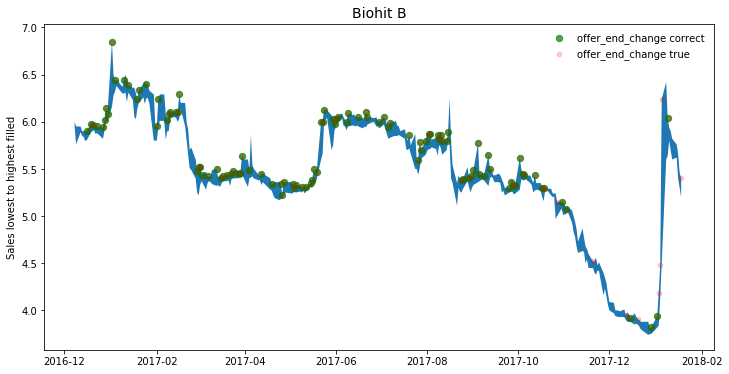

Biohit B   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.0s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.0s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.68      0.95      0.79       547
       rise       0.90      0.47      0.62       468

avg / total       0.78      0.73      0.71      1015

[[522  25]
 [249 219]]
Train roc_auc = 0.837

Test set classification
             precision    recall  f1-score   support

   not rise       0.77      0.86      0.81        51
       rise       0.46      0.32      0.37        19

avg / total       0.69      0.71      0.70        70

[[44  7]
 [13  6]]
Test roc_auc = 0.656

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 30}


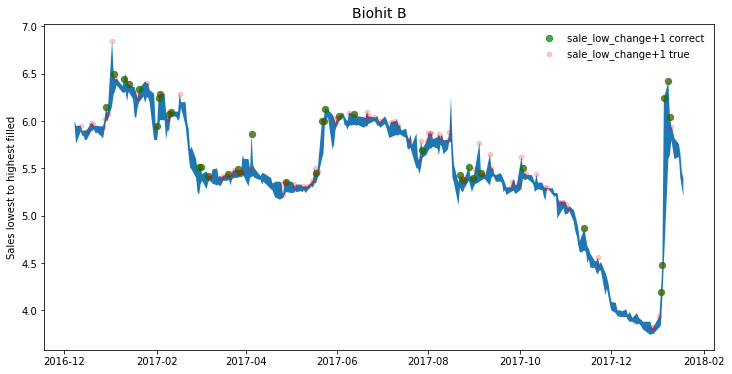

Biohit B   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.0s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.2s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       547
       rise       1.00      1.00      1.00       468

avg / total       1.00      1.00      1.00      1015

[[547   0]
 [  0 468]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.79      0.73      0.76        51
       rise       0.39      0.47      0.43        19

avg / total       0.68      0.66      0.67        70

[[37 14]
 [10  9]]
Test roc_auc = 0.621

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 250, 'sel__k': 10}


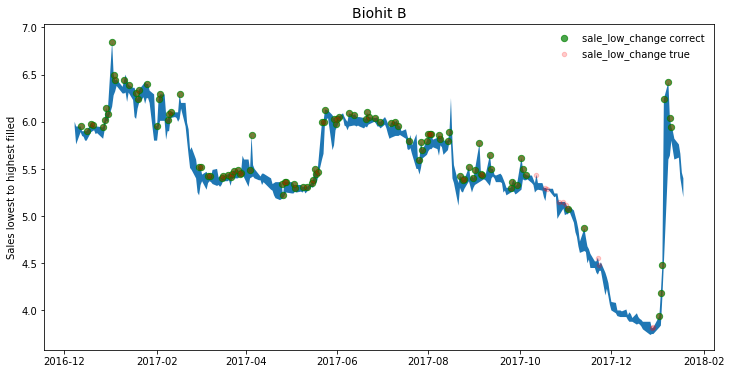

Biohit B   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 641 tasks      | elapsed:   45.6s
[Parallel(n_jobs=5)]: Done 991 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1441 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1991 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2641 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3391 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4241 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       604
       rise       1.00      1.00      1.00       411

avg / total       1.00      1.00      1.00      1015

[[604   0]
 [  1 410]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.81      0.82      0.81        56
       rise       0.23      0.21      0.22        14

avg / total       0.69      0.70      0.70        70

[[46 10]
 [11  3]]
Test roc_auc = 0.571

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 250, 'sel__k': 40}


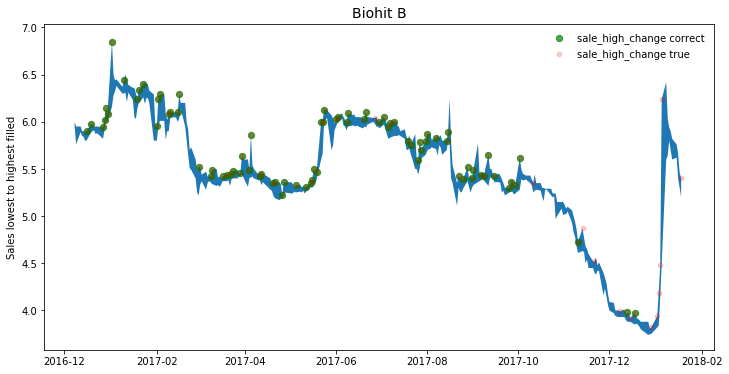

Caverion   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   47.7s
[Parallel(n_jobs=5)]: Done 988 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1438 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 1988 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 2638 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 3388 tasks      | elapsed:  5.6min
[Parallel(n_jobs=5)]: Done 4238 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.9min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       506
       rise       1.00      1.00      1.00       509

avg / total       1.00      1.00      1.00      1015

[[506   0]
 [  0 509]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.51      0.56        41
       rise       0.44      0.55      0.49        29

avg / total       0.55      0.53      0.53        70

[[21 20]
 [13 16]]
Test roc_auc = 0.516

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 300, 'sel__k': 40}


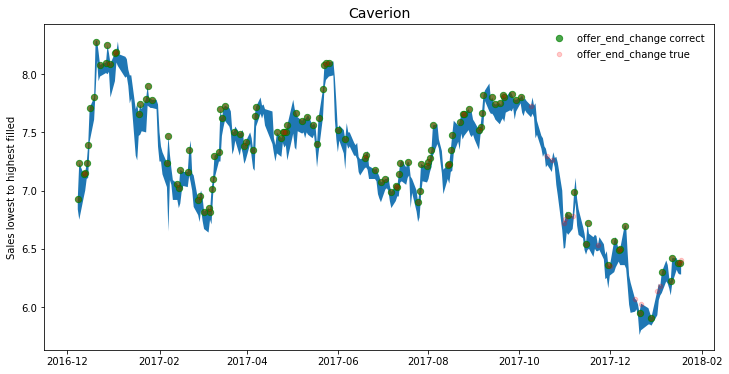

Caverion   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.9s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  8.0min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.68      0.77      0.72       483
       rise       0.76      0.67      0.71       532

avg / total       0.72      0.72      0.72      1015

[[372 111]
 [175 357]]
Train roc_auc = 0.813

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.76      0.72        42
       rise       0.57      0.46      0.51        28

avg / total       0.63      0.64      0.64        70

[[32 10]
 [15 13]]
Test roc_auc = 0.654

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 10}


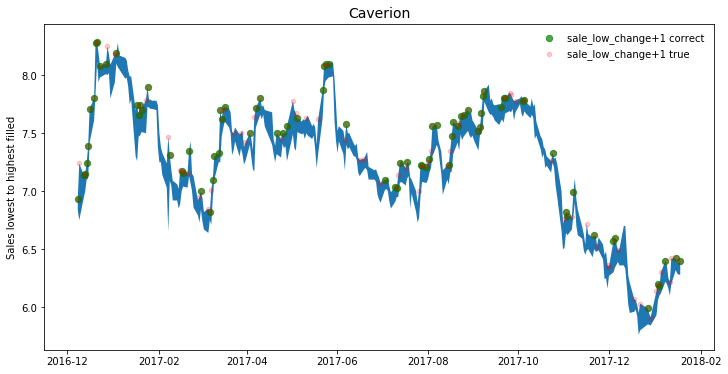

Caverion   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.7s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   47.1s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.9min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.82      0.86      0.84       483
       rise       0.86      0.83      0.84       532

avg / total       0.84      0.84      0.84      1015

[[413  70]
 [ 92 440]]
Train roc_auc = 0.922

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.64      0.66        42
       rise       0.50      0.54      0.52        28

avg / total       0.60      0.60      0.60        70

[[27 15]
 [13 15]]
Test roc_auc = 0.631

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 100, 'sel__k': 10}


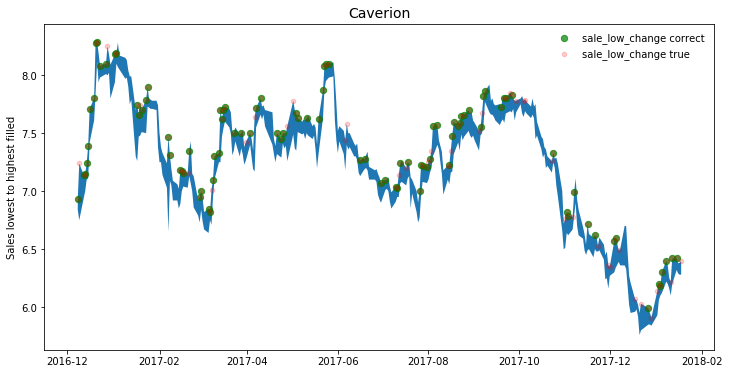

Caverion   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   22.3s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   48.1s
[Parallel(n_jobs=5)]: Done 988 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1988 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2638 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3388 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4238 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.9min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       534
       rise       1.00      1.00      1.00       481

avg / total       1.00      1.00      1.00      1015

[[534   0]
 [  0 481]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.69      0.67      0.68        43
       rise       0.50      0.52      0.51        27

avg / total       0.62      0.61      0.62        70

[[29 14]
 [13 14]]
Test roc_auc = 0.667

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 100, 'sel__k': 40}


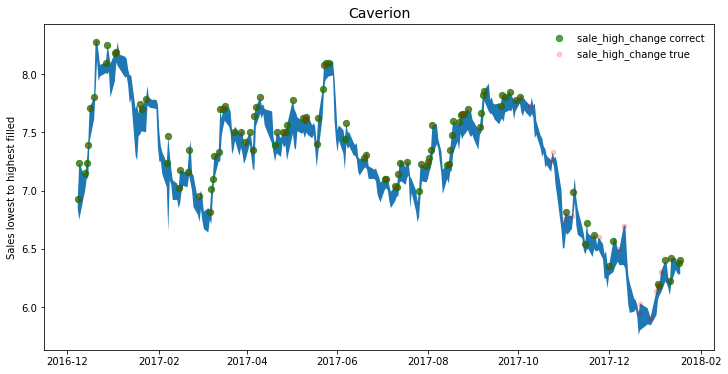

Digia   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   42.1s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       585
       rise       1.00      1.00      1.00       430

avg / total       1.00      1.00      1.00      1015

[[585   0]
 [  0 430]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.69      0.65      0.67        48
       rise       0.32      0.36      0.34        22

avg / total       0.57      0.56      0.56        70

[[31 17]
 [14  8]]
Test roc_auc = 0.494

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


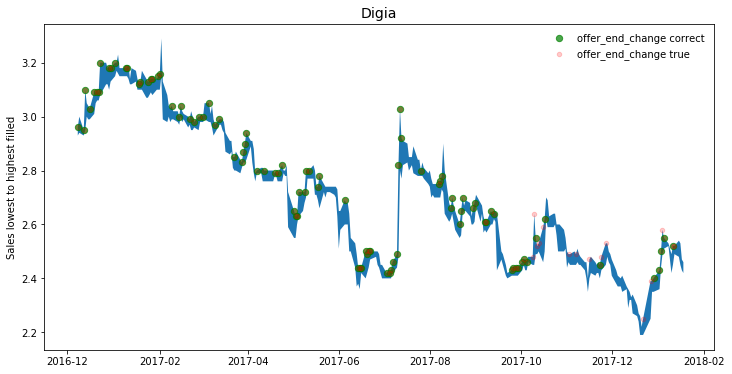

Digia   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       555
       rise       1.00      1.00      1.00       460

avg / total       1.00      1.00      1.00      1015

[[555   0]
 [  0 460]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.76      0.74      0.75        43
       rise       0.61      0.63      0.62        27

avg / total       0.70      0.70      0.70        70

[[32 11]
 [10 17]]
Test roc_auc = 0.711

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 250, 'sel__k': 40}


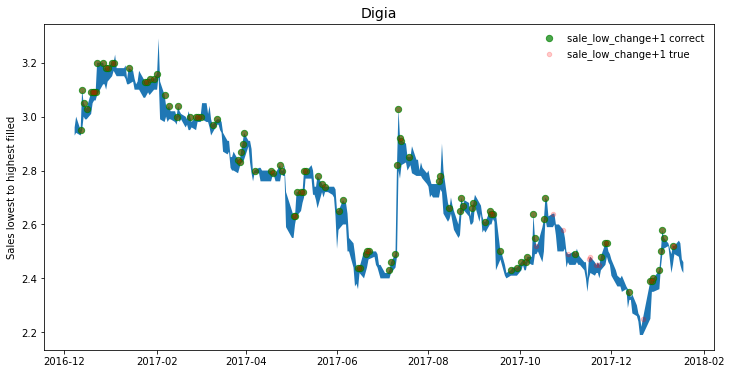

Digia   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.5s
[Parallel(n_jobs=5)]: Done 640 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 990 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1990 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3390 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4240 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.71      0.91      0.80       555
       rise       0.84      0.55      0.67       460

avg / total       0.77      0.75      0.74      1015

[[507  48]
 [205 255]]
Train roc_auc = 0.819

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.79      0.73        43
       rise       0.55      0.41      0.47        27

avg / total       0.63      0.64      0.63        70

[[34  9]
 [16 11]]
Test roc_auc = 0.616

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 20}


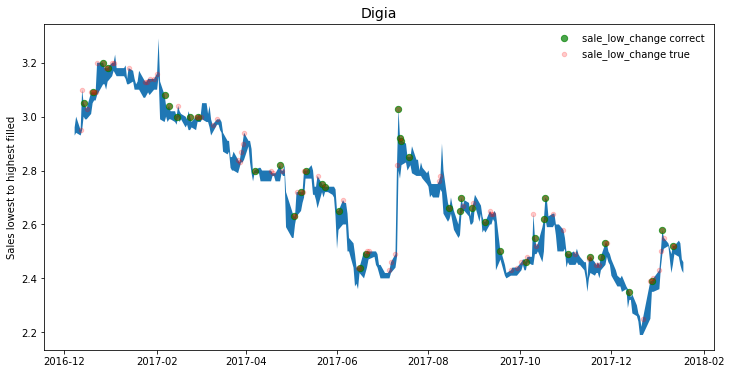

Digia   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 644 tasks      | elapsed:   42.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1444 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1994 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2644 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3394 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4244 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       612
       rise       1.00      1.00      1.00       403

avg / total       1.00      1.00      1.00      1015

[[612   0]
 [  0 403]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.63      0.76      0.69        45
       rise       0.31      0.20      0.24        25

avg / total       0.52      0.56      0.53        70

[[34 11]
 [20  5]]
Test roc_auc = 0.515

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 100, 'sel__k': 40}


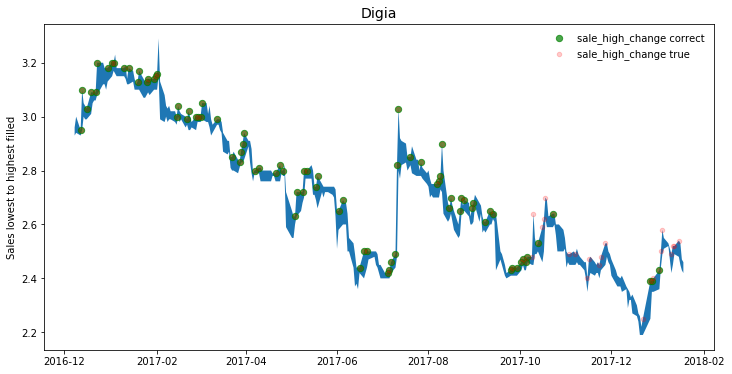

Metsä Board A   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.4s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   42.5s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.94      0.96      0.95       512
       rise       0.96      0.93      0.95       503

avg / total       0.95      0.95      0.95      1015

[[494  18]
 [ 34 469]]
Train roc_auc = 0.993

Test set classification
             precision    recall  f1-score   support

   not rise       0.36      0.48      0.41        27
       rise       0.59      0.47      0.52        43

avg / total       0.50      0.47      0.48        70

[[13 14]
 [23 20]]
Test roc_auc = 0.472

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 100, 'sel__k': 30}


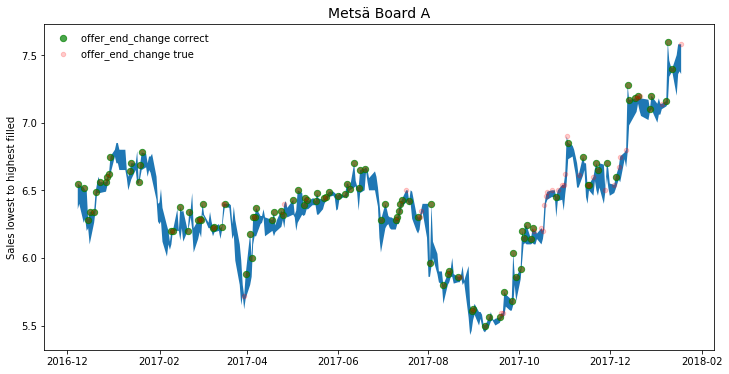

Metsä Board A   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 416 tasks      | elapsed:   23.7s
[Parallel(n_jobs=5)]: Done 668 tasks      | elapsed:   42.5s
[Parallel(n_jobs=5)]: Done 1018 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1468 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 2018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2668 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 3418 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4268 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.1min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.89      0.96      0.92       502
       rise       0.96      0.88      0.92       513

avg / total       0.92      0.92      0.92      1015

[[482  20]
 [ 61 452]]
Train roc_auc = 0.981

Test set classification
             precision    recall  f1-score   support

   not rise       0.46      0.44      0.45        27
       rise       0.66      0.67      0.67        43

avg / total       0.58      0.59      0.58        70

[[12 15]
 [14 29]]
Test roc_auc = 0.568

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 150, 'sel__k': 10}


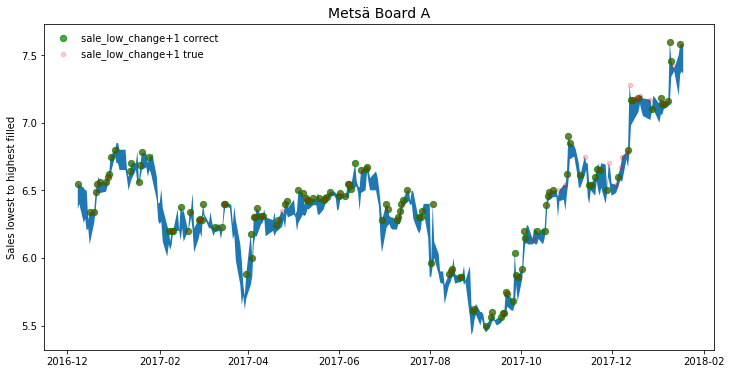

Metsä Board A   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   18.6s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   40.9s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.1min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       502
       rise       1.00      1.00      1.00       513

avg / total       1.00      1.00      1.00      1015

[[502   0]
 [  0 513]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.43      0.37      0.40        27
       rise       0.64      0.70      0.67        43

avg / total       0.56      0.57      0.56        70

[[10 17]
 [13 30]]
Test roc_auc = 0.635

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 150, 'sel__k': 30}


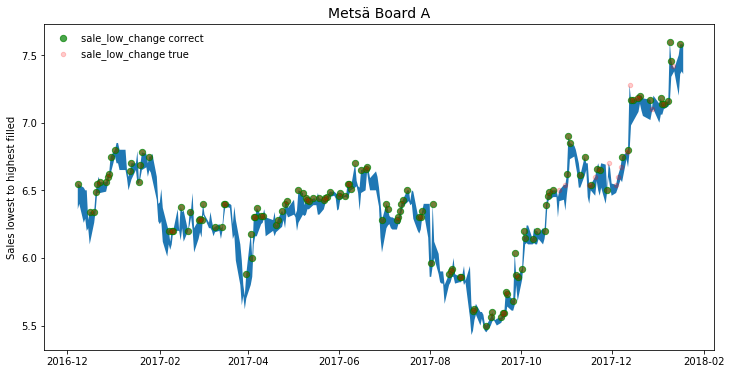

Metsä Board A   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   42.3s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.86      0.91      0.88       534
       rise       0.89      0.83      0.86       481

avg / total       0.87      0.87      0.87      1015

[[484  50]
 [ 81 400]]
Train roc_auc = 0.946

Test set classification
             precision    recall  f1-score   support

   not rise       0.57      0.57      0.57        30
       rise       0.68      0.68      0.68        40

avg / total       0.63      0.63      0.63        70

[[17 13]
 [13 27]]
Test roc_auc = 0.611

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 30}


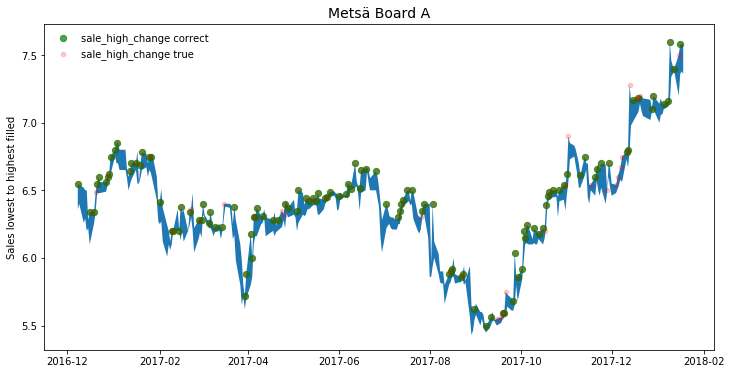

Panostaja   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   15.3s
[Parallel(n_jobs=5)]: Done 649 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 999 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1449 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1999 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 2649 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 3399 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 4249 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  6.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.76      0.96      0.85       666
       rise       0.84      0.43      0.57       349

avg / total       0.79      0.78      0.75      1015

[[637  29]
 [198 151]]
Train roc_auc = 0.807

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.93      0.74        42
       rise       0.57      0.14      0.23        28

avg / total       0.60      0.61      0.54        70

[[39  3]
 [24  4]]
Test roc_auc = 0.589

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 30}


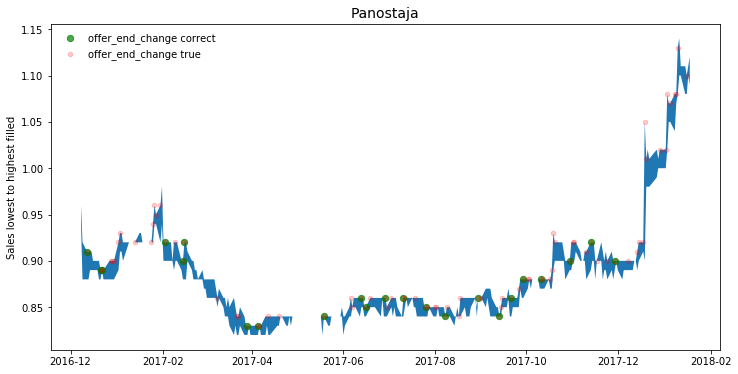

Panostaja   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 504 tasks      | elapsed:   24.6s
[Parallel(n_jobs=5)]: Done 754 tasks      | elapsed:   53.5s
[Parallel(n_jobs=5)]: Done 1104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 2104 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 2754 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 3504 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 4354 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.9min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       682
       rise       1.00      1.00      1.00       333

avg / total       1.00      1.00      1.00      1015

[[682   0]
 [  0 333]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.85      0.72        39
       rise       0.65      0.35      0.46        31

avg / total       0.63      0.63      0.60        70

[[33  6]
 [20 11]]
Test roc_auc = 0.762

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 300, 'sel__k': 30}


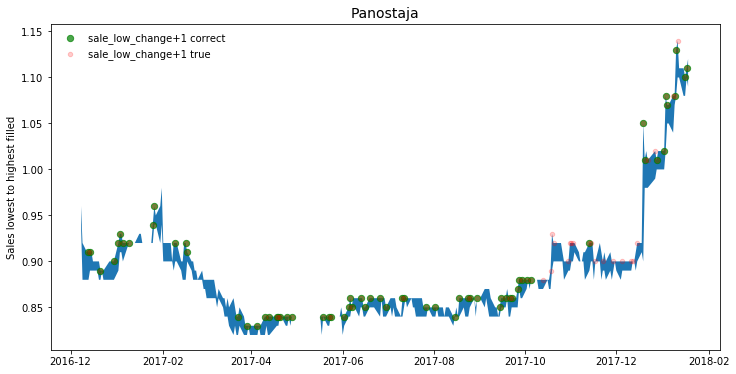

Panostaja   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 503 tasks      | elapsed:   24.8s
[Parallel(n_jobs=5)]: Done 753 tasks      | elapsed:   53.3s
[Parallel(n_jobs=5)]: Done 1103 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1553 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 2103 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 2753 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 3503 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 4353 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.9min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.75      0.98      0.85       682
       rise       0.89      0.32      0.47       333

avg / total       0.79      0.76      0.72      1015

[[669  13]
 [227 106]]
Train roc_auc = 0.818

Test set classification
             precision    recall  f1-score   support

   not rise       0.61      0.97      0.75        39
       rise       0.88      0.23      0.36        31

avg / total       0.73      0.64      0.58        70

[[38  1]
 [24  7]]
Test roc_auc = 0.783

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 40}


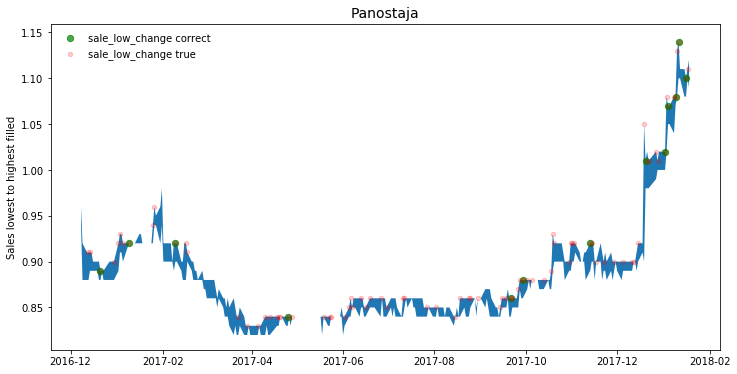

Panostaja   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:   24.7s
[Parallel(n_jobs=5)]: Done 756 tasks      | elapsed:   53.2s
[Parallel(n_jobs=5)]: Done 1106 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1556 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 2106 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 2756 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 3506 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 4356 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  6.0min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.89      0.99      0.94       725
       rise       0.97      0.68      0.80       290

avg / total       0.91      0.90      0.90      1015

[[718   7]
 [ 92 198]]
Train roc_auc = 0.964

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.91      0.78        46
       rise       0.50      0.17      0.25        24

avg / total       0.62      0.66      0.60        70

[[42  4]
 [20  4]]
Test roc_auc = 0.479

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


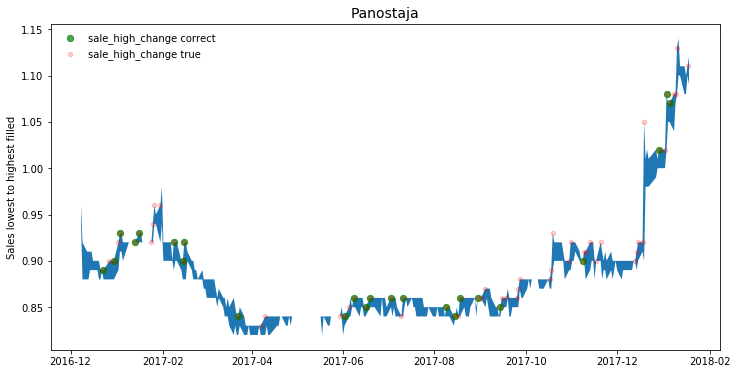

SRV Yhtiöt   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:   25.4s
[Parallel(n_jobs=5)]: Done 663 tasks      | elapsed:   46.6s
[Parallel(n_jobs=5)]: Done 1013 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1463 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 2013 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2663 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3413 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4263 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       531
       rise       1.00      1.00      1.00       484

avg / total       1.00      1.00      1.00      1015

[[531   0]
 [  0 484]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.73      0.50      0.59        44
       rise       0.45      0.69      0.55        26

avg / total       0.63      0.57      0.58        70

[[22 22]
 [ 8 18]]
Test roc_auc = 0.614

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 10, 'gbm__n_estimators': 50, 'sel__k': 40}


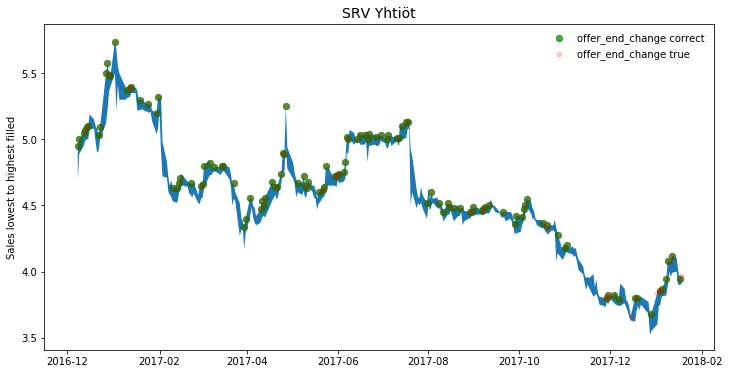

SRV Yhtiöt   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:   25.9s
[Parallel(n_jobs=5)]: Done 663 tasks      | elapsed:   47.1s
[Parallel(n_jobs=5)]: Done 1013 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1463 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 2013 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2663 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3413 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4263 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.81      0.96      0.88       524
       rise       0.94      0.76      0.84       491

avg / total       0.87      0.86      0.86      1015

[[502  22]
 [120 371]]
Train roc_auc = 0.949

Test set classification
             precision    recall  f1-score   support

   not rise       0.76      0.72      0.74        43
       rise       0.59      0.63      0.61        27

avg / total       0.69      0.69      0.69        70

[[31 12]
 [10 17]]
Test roc_auc = 0.704

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 10, 'gbm__n_estimators': 50, 'sel__k': 30}


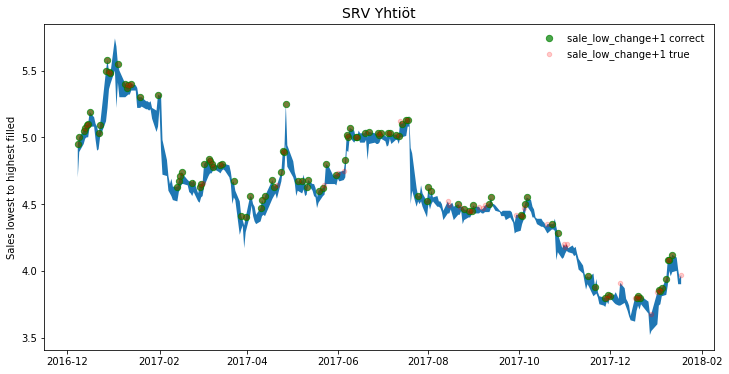

SRV Yhtiöt   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.7s
[Parallel(n_jobs=5)]: Done 640 tasks      | elapsed:   45.3s
[Parallel(n_jobs=5)]: Done 990 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1990 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3390 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4240 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.71      0.90      0.79       524
       rise       0.85      0.61      0.71       491

avg / total       0.78      0.76      0.75      1015

[[471  53]
 [193 298]]
Train roc_auc = 0.858

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.70      0.69        43
       rise       0.50      0.48      0.49        27

avg / total       0.61      0.61      0.61        70

[[30 13]
 [14 13]]
Test roc_auc = 0.615

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 40}


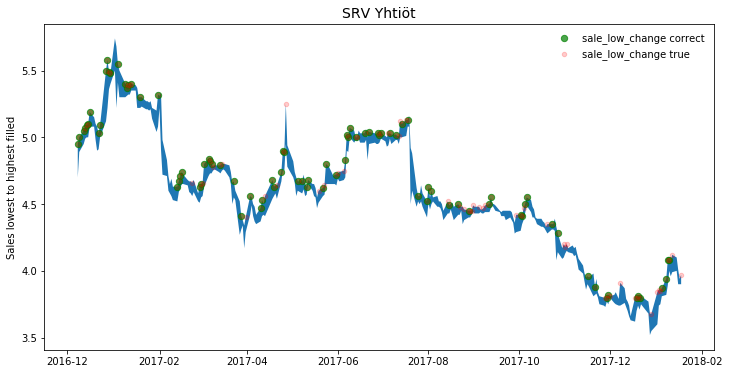

SRV Yhtiöt   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done 663 tasks      | elapsed:   47.7s
[Parallel(n_jobs=5)]: Done 1013 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1463 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 2013 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2663 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3413 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4263 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       584
       rise       1.00      1.00      1.00       431

avg / total       1.00      1.00      1.00      1015

[[584   0]
 [  0 431]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.69      0.73      0.71        48
       rise       0.32      0.27      0.29        22

avg / total       0.57      0.59      0.58        70

[[35 13]
 [16  6]]
Test roc_auc = 0.526

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 250, 'sel__k': 10}


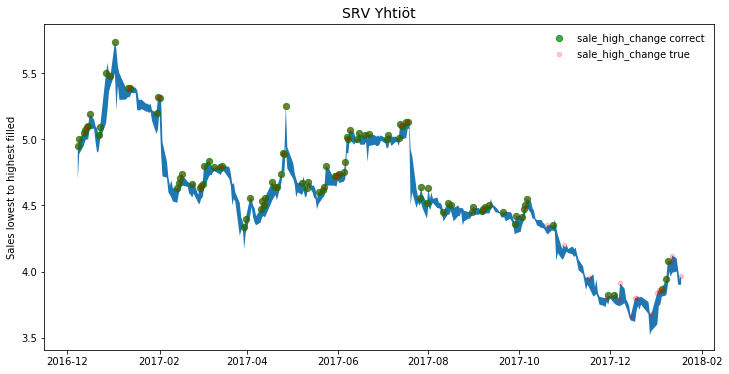

SSH Comm. Security   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.3s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.99      1.00      0.99       602
       rise       1.00      0.98      0.99       413

avg / total       0.99      0.99      0.99      1015

[[600   2]
 [  7 406]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.65      0.68      0.67        47
       rise       0.29      0.26      0.27        23

avg / total       0.53      0.54      0.54        70

[[32 15]
 [17  6]]
Test roc_auc = 0.394

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 200, 'sel__k': 40}


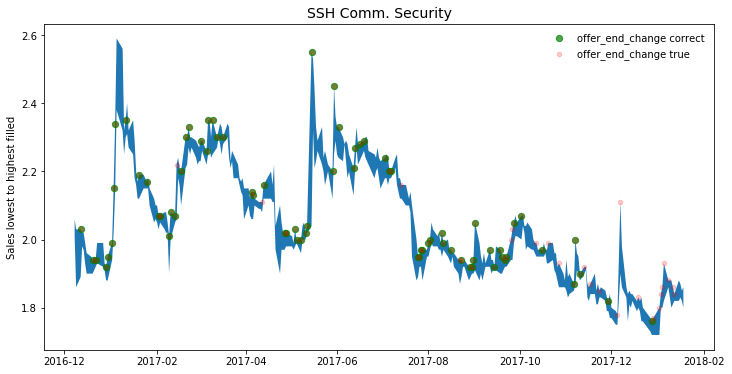

SSH Comm. Security   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.8s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       566
       rise       1.00      1.00      1.00       449

avg / total       1.00      1.00      1.00      1015

[[566   0]
 [  0 449]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.73      0.70      0.72        47
       rise       0.44      0.48      0.46        23

avg / total       0.64      0.63      0.63        70

[[33 14]
 [12 11]]
Test roc_auc = 0.556

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 250, 'sel__k': 10}


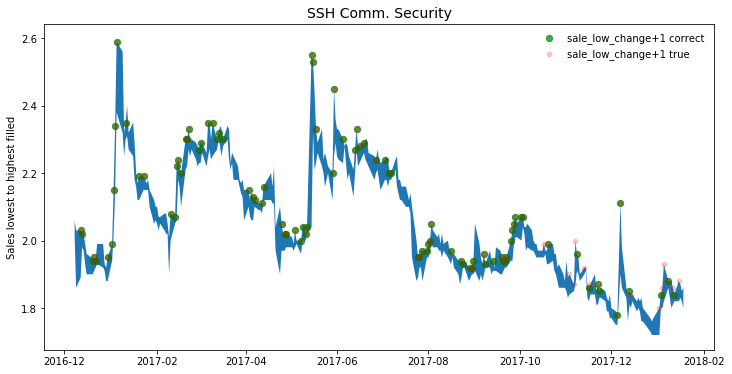

SSH Comm. Security   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.5s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.99      1.00      0.99       566
       rise       1.00      0.99      0.99       449

avg / total       0.99      0.99      0.99      1015

[[566   0]
 [  6 443]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.77      0.72        47
       rise       0.35      0.26      0.30        23

avg / total       0.57      0.60      0.58        70

[[36 11]
 [17  6]]
Test roc_auc = 0.540

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 100, 'sel__k': 30}


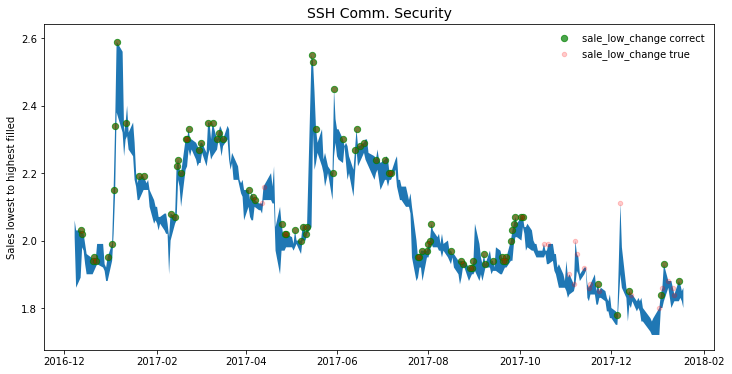

SSH Comm. Security   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.7s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.7s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       646
       rise       1.00      1.00      1.00       369

avg / total       1.00      1.00      1.00      1015

[[646   0]
 [  0 369]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.70      0.74      0.72        50
       rise       0.24      0.20      0.22        20

avg / total       0.57      0.59      0.57        70

[[37 13]
 [16  4]]
Test roc_auc = 0.607

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 300, 'sel__k': 30}


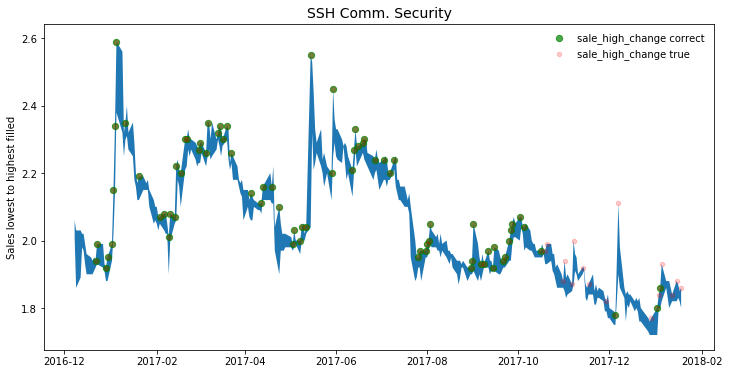

Saga Furs C   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 640 tasks      | elapsed:   44.8s
[Parallel(n_jobs=5)]: Done 990 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1990 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3390 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4240 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       563
       rise       1.00      1.00      1.00       452

avg / total       1.00      1.00      1.00      1015

[[563   0]
 [  0 452]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.55      0.66      0.60        41
       rise       0.33      0.24      0.28        29

avg / total       0.46      0.49      0.47        70

[[27 14]
 [22  7]]
Test roc_auc = 0.407

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 200, 'sel__k': 40}


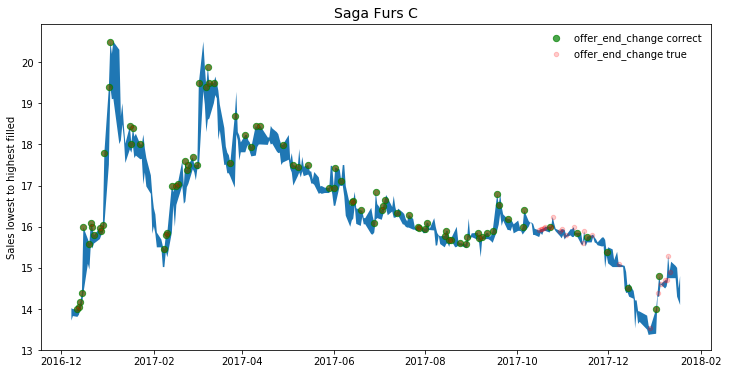

Saga Furs C   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.7s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.7s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.93      1.00      0.97       545
       rise       1.00      0.92      0.96       470

avg / total       0.96      0.96      0.96      1015

[[545   0]
 [ 39 431]]
Train roc_auc = 0.998

Test set classification
             precision    recall  f1-score   support

   not rise       0.67      0.76      0.71        46
       rise       0.39      0.29      0.33        24

avg / total       0.58      0.60      0.58        70

[[35 11]
 [17  7]]
Test roc_auc = 0.658

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 100, 'sel__k': 40}


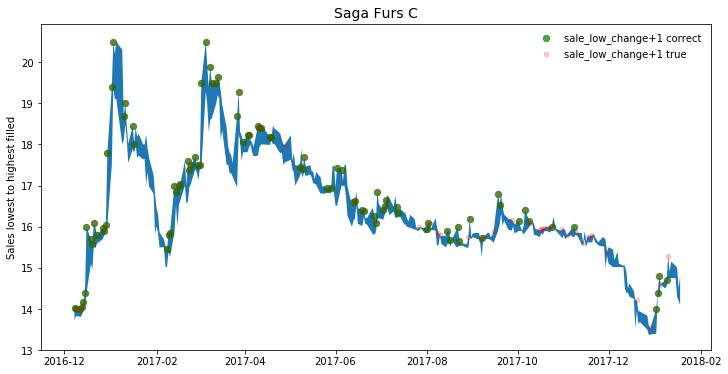

Saga Furs C   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 411 tasks      | elapsed:   26.3s
[Parallel(n_jobs=5)]: Done 662 tasks      | elapsed:   48.8s
[Parallel(n_jobs=5)]: Done 1012 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1462 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 2012 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2662 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3412 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4262 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.98      1.00      0.99       545
       rise       1.00      0.98      0.99       470

avg / total       0.99      0.99      0.99      1015

[[544   1]
 [ 10 460]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.70      0.69        46
       rise       0.39      0.38      0.38        24

avg / total       0.58      0.59      0.58        70

[[32 14]
 [15  9]]
Test roc_auc = 0.566

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 10}


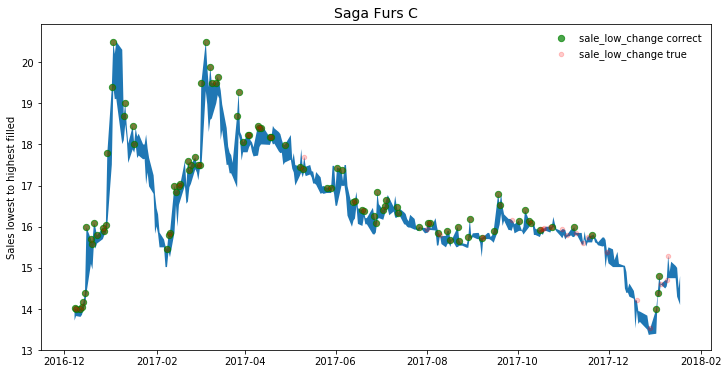

Saga Furs C   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   46.7s
[Parallel(n_jobs=5)]: Done 988 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1988 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2638 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3388 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4238 tasks      | elapsed:  6.7min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.8min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.97      0.99      0.98       593
       rise       0.98      0.95      0.97       422

avg / total       0.97      0.97      0.97      1015

[[585   8]
 [ 20 402]]
Train roc_auc = 0.998

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.60      0.64        45
       rise       0.40      0.48      0.44        25

avg / total       0.58      0.56      0.56        70

[[27 18]
 [13 12]]
Test roc_auc = 0.516

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 10, 'gbm__n_estimators': 50, 'sel__k': 20}


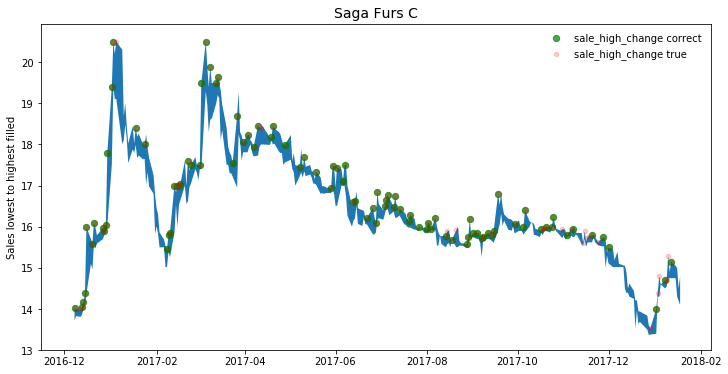

Scanfil   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:   25.6s
[Parallel(n_jobs=5)]: Done 663 tasks      | elapsed:   46.4s
[Parallel(n_jobs=5)]: Done 1013 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1463 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 2013 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2663 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3413 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4263 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       543
       rise       1.00      1.00      1.00       472

avg / total       1.00      1.00      1.00      1015

[[543   0]
 [  0 472]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.61      0.53      0.56        38
       rise       0.51      0.59      0.55        32

avg / total       0.56      0.56      0.56        70

[[20 18]
 [13 19]]
Test roc_auc = 0.596

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 350, 'sel__k': 10}


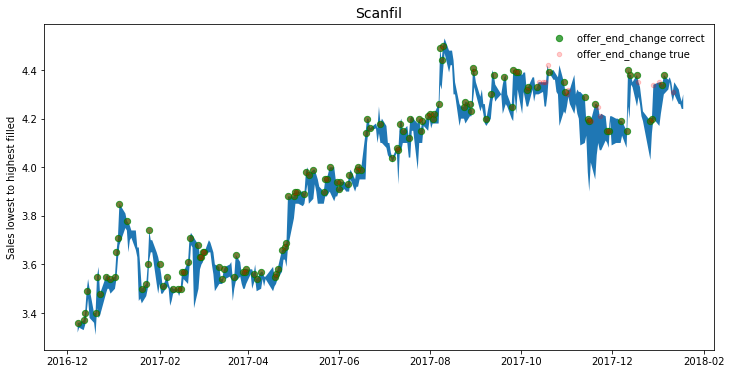

Scanfil   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.9s
[Parallel(n_jobs=5)]: Done 641 tasks      | elapsed:   44.0s
[Parallel(n_jobs=5)]: Done 991 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1441 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1991 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2641 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 3391 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 4241 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.68      0.82      0.74       524
       rise       0.76      0.58      0.66       491

avg / total       0.72      0.71      0.70      1015

[[431  93]
 [204 287]]
Train roc_auc = 0.790

Test set classification
             precision    recall  f1-score   support

   not rise       0.64      0.83      0.72        36
       rise       0.74      0.50      0.60        34

avg / total       0.69      0.67      0.66        70

[[30  6]
 [17 17]]
Test roc_auc = 0.705

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 10}


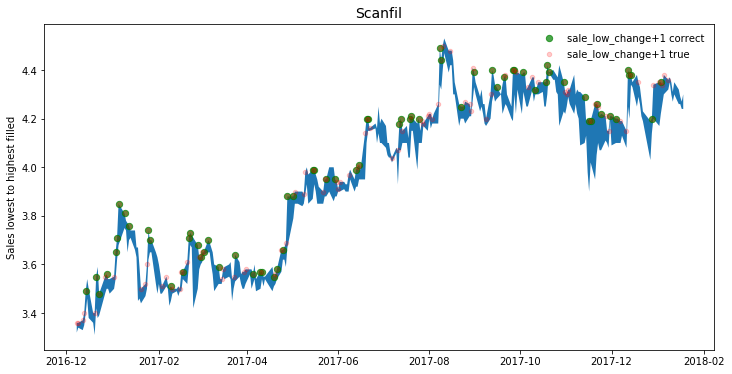

Scanfil   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 414 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done 664 tasks      | elapsed:   46.4s
[Parallel(n_jobs=5)]: Done 1014 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1464 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 2014 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2664 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3414 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 4264 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.71      0.85      0.77       524
       rise       0.80      0.64      0.71       491

avg / total       0.75      0.75      0.74      1015

[[444  80]
 [178 313]]
Train roc_auc = 0.830

Test set classification
             precision    recall  f1-score   support

   not rise       0.68      0.83      0.75        36
       rise       0.77      0.59      0.67        34

avg / total       0.72      0.71      0.71        70

[[30  6]
 [14 20]]
Test roc_auc = 0.709

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 20}


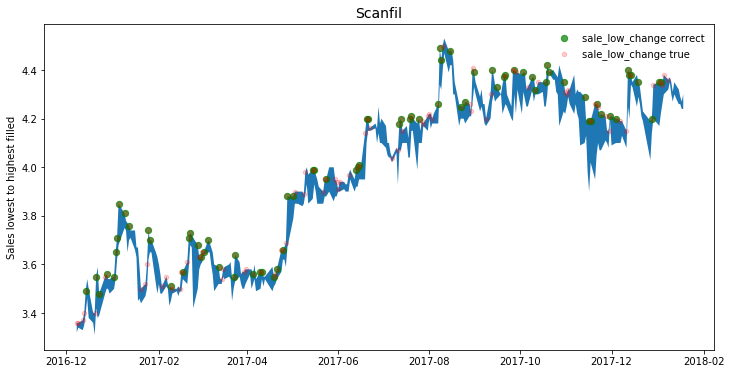

Scanfil   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.9s
[Parallel(n_jobs=5)]: Done 641 tasks      | elapsed:   43.5s
[Parallel(n_jobs=5)]: Done 991 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1441 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1991 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2641 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 3391 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 4241 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       575
       rise       1.00      1.00      1.00       440

avg / total       1.00      1.00      1.00      1015

[[575   0]
 [  0 440]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.78      0.66      0.71        47
       rise       0.47      0.61      0.53        23

avg / total       0.67      0.64      0.65        70

[[31 16]
 [ 9 14]]
Test roc_auc = 0.714

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 200, 'sel__k': 30}


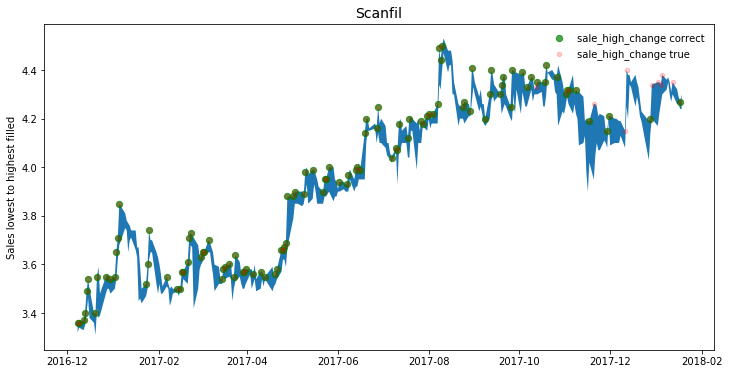

Stora Enso A   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 411 tasks      | elapsed:   26.8s
[Parallel(n_jobs=5)]: Done 662 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 1012 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1462 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 2012 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 2662 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3412 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4262 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       473
       rise       1.00      1.00      1.00       542

avg / total       1.00      1.00      1.00      1015

[[473   0]
 [  0 542]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.58      0.44      0.50        34
       rise       0.57      0.69      0.62        36

avg / total       0.57      0.57      0.56        70

[[15 19]
 [11 25]]
Test roc_auc = 0.492

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


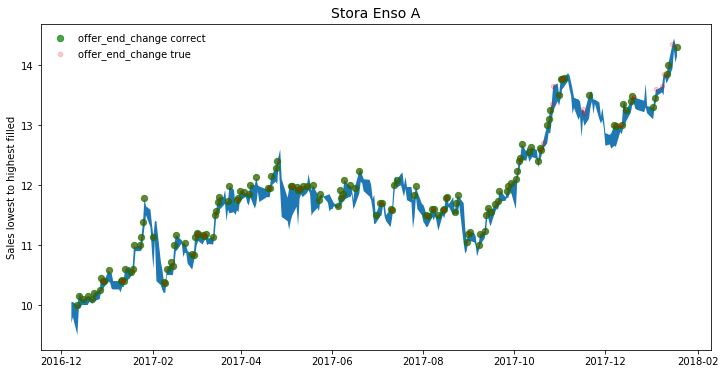

Stora Enso A   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   47.3s
[Parallel(n_jobs=5)]: Done 988 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1988 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2638 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3388 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4238 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       467
       rise       1.00      1.00      1.00       548

avg / total       1.00      1.00      1.00      1015

[[467   0]
 [  0 548]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.45      0.43      0.44        30
       rise       0.59      0.60      0.59        40

avg / total       0.53      0.53      0.53        70

[[13 17]
 [16 24]]
Test roc_auc = 0.518

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 350, 'sel__k': 30}


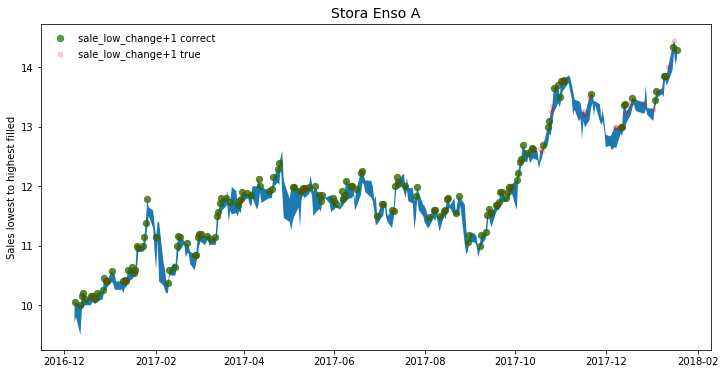

Stora Enso A   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 409 tasks      | elapsed:   26.8s
[Parallel(n_jobs=5)]: Done 660 tasks      | elapsed:   49.7s
[Parallel(n_jobs=5)]: Done 1010 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1460 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 2010 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 2660 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3410 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 4260 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.99      1.00      0.99       467
       rise       1.00      0.99      1.00       548

avg / total       1.00      1.00      1.00      1015

[[465   2]
 [  3 545]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.29      0.27      0.28        30
       rise       0.48      0.50      0.49        40

avg / total       0.39      0.40      0.40        70

[[ 8 22]
 [20 20]]
Test roc_auc = 0.478

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 200, 'sel__k': 10}


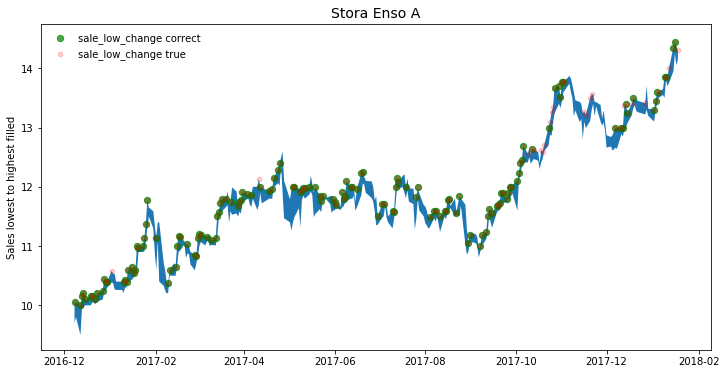

Stora Enso A   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.8s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.88      0.79      0.84       498
       rise       0.82      0.90      0.86       517

avg / total       0.85      0.85      0.85      1015

[[395 103]
 [ 52 465]]
Train roc_auc = 0.939

Test set classification
             precision    recall  f1-score   support

   not rise       0.45      0.27      0.34        33
       rise       0.52      0.70      0.60        37

avg / total       0.49      0.50      0.48        70

[[ 9 24]
 [11 26]]
Test roc_auc = 0.456

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 100, 'sel__k': 10}


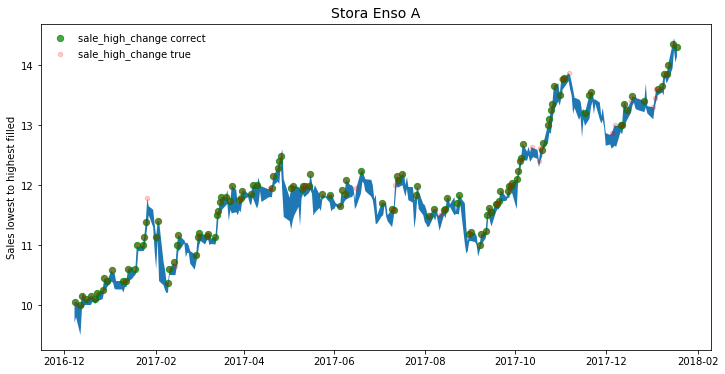

Suominen   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 416 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 668 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 1018 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1468 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 2018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2668 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 3418 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4268 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.97      1.00      0.98       598
       rise       1.00      0.95      0.98       417

avg / total       0.98      0.98      0.98      1015

[[597   1]
 [ 19 398]]
Train roc_auc = 0.996

Test set classification
             precision    recall  f1-score   support

   not rise       0.53      0.49      0.51        41
       rise       0.34      0.38      0.36        29

avg / total       0.45      0.44      0.45        70

[[20 21]
 [18 11]]
Test roc_auc = 0.439

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 10, 'gbm__n_estimators': 150, 'sel__k': 30}


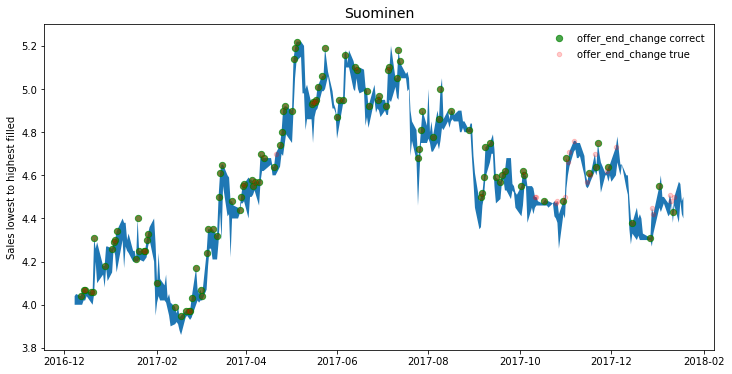

Suominen   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   41.3s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.78      0.95      0.85       602
       rise       0.88      0.61      0.72       413

avg / total       0.82      0.81      0.80      1015

[[569  33]
 [160 253]]
Train roc_auc = 0.895

Test set classification
             precision    recall  f1-score   support

   not rise       0.65      0.89      0.75        44
       rise       0.50      0.19      0.28        26

avg / total       0.59      0.63      0.57        70

[[39  5]
 [21  5]]
Test roc_auc = 0.508

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 20}


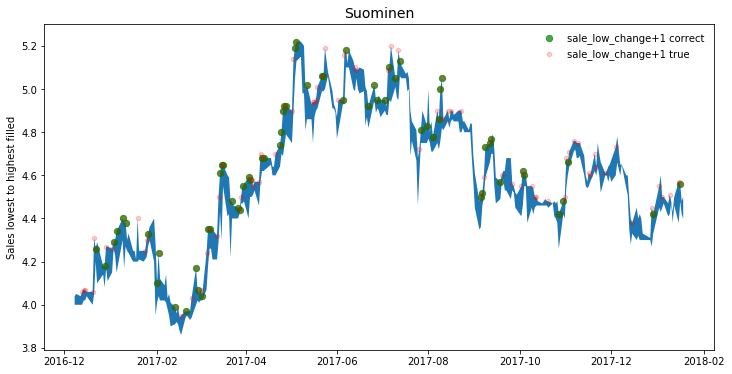

Suominen   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 416 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 666 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 1016 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1466 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 2016 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2666 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3416 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4266 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.86      0.98      0.92       602
       rise       0.96      0.78      0.86       413

avg / total       0.90      0.90      0.89      1015

[[589  13]
 [ 92 321]]
Train roc_auc = 0.960

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.75      0.68        44
       rise       0.35      0.23      0.28        26

avg / total       0.52      0.56      0.53        70

[[33 11]
 [20  6]]
Test roc_auc = 0.475

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 100, 'sel__k': 40}


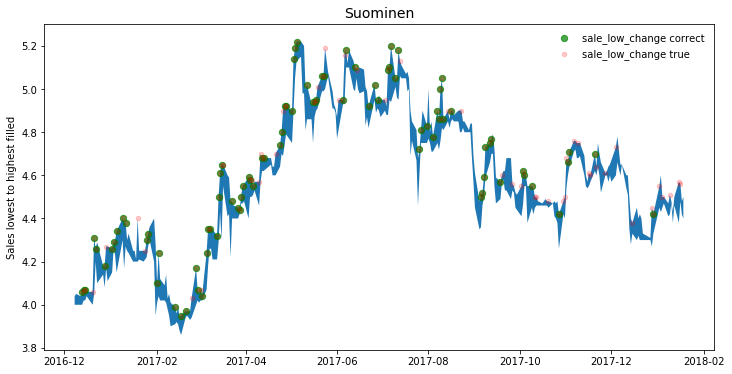

Suominen   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 644 tasks      | elapsed:   40.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1444 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 1994 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2644 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 3394 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4244 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.89      1.00      0.94       626
       rise       1.00      0.79      0.89       389

avg / total       0.93      0.92      0.92      1015

[[626   0]
 [ 80 309]]
Train roc_auc = 0.990

Test set classification
             precision    recall  f1-score   support

   not rise       0.58      0.76      0.66        41
       rise       0.41      0.24      0.30        29

avg / total       0.51      0.54      0.51        70

[[31 10]
 [22  7]]
Test roc_auc = 0.491

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 150, 'sel__k': 40}


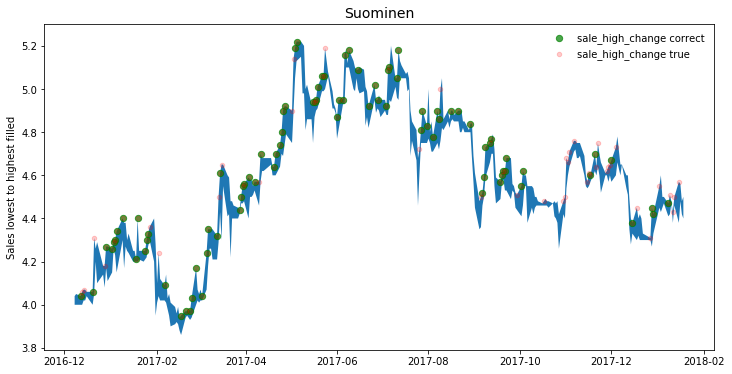

Teleste   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   46.4s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       504
       rise       1.00      1.00      1.00       511

avg / total       1.00      1.00      1.00      1015

[[504   0]
 [  0 511]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.51      0.56        45
       rise       0.33      0.44      0.38        25

avg / total       0.52      0.49      0.50        70

[[23 22]
 [14 11]]
Test roc_auc = 0.497

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


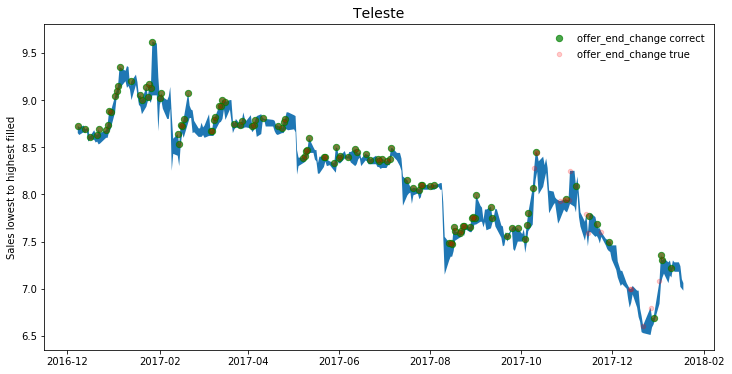

Teleste   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   44.8s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.4min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       499
       rise       1.00      1.00      1.00       516

avg / total       1.00      1.00      1.00      1015

[[499   0]
 [  0 516]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.64      0.39      0.49        46
       rise       0.33      0.58      0.42        24

avg / total       0.54      0.46      0.47        70

[[18 28]
 [10 14]]
Test roc_auc = 0.570

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 250, 'sel__k': 40}


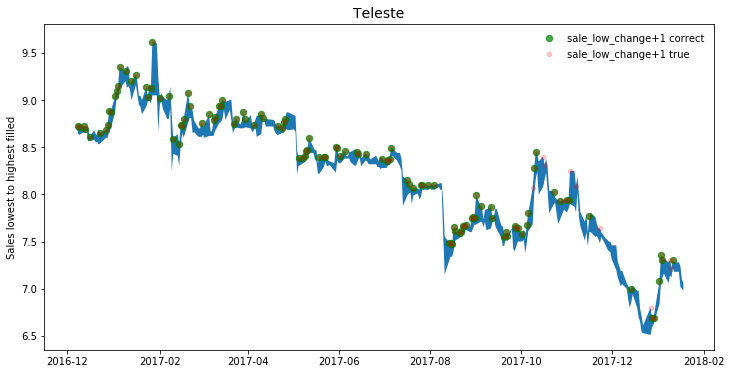

Teleste   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.8s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       499
       rise       1.00      1.00      1.00       516

avg / total       1.00      1.00      1.00      1015

[[499   0]
 [  0 516]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.63      0.48      0.54        46
       rise       0.31      0.46      0.37        24

avg / total       0.52      0.47      0.48        70

[[22 24]
 [13 11]]
Test roc_auc = 0.500

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 200, 'sel__k': 40}


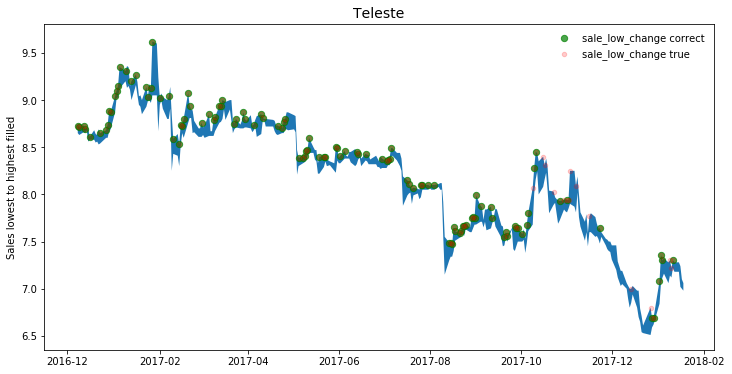

Teleste   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   20.7s
[Parallel(n_jobs=5)]: Done 639 tasks      | elapsed:   45.4s
[Parallel(n_jobs=5)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1439 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2639 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 3389 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 4239 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       530
       rise       1.00      1.00      1.00       485

avg / total       1.00      1.00      1.00      1015

[[530   0]
 [  0 485]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.83      0.52      0.64        56
       rise       0.23      0.57      0.33        14

avg / total       0.71      0.53      0.58        70

[[29 27]
 [ 6  8]]
Test roc_auc = 0.622

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


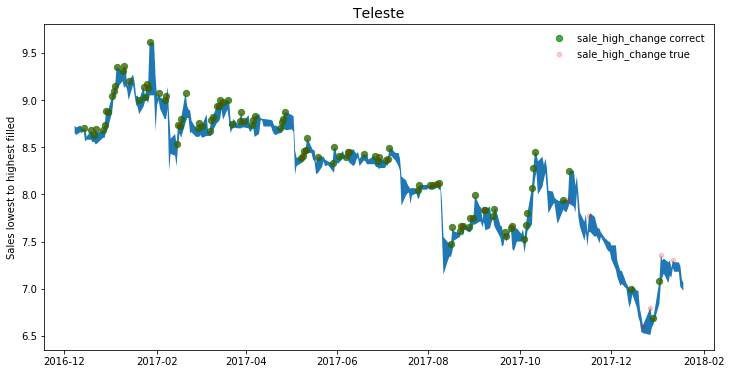

Tulikivi A   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   13.3s
[Parallel(n_jobs=5)]: Done 797 tasks      | elapsed:   47.1s
[Parallel(n_jobs=5)]: Done 1147 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1819 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 2443 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 3242 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 4218 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.81      0.99      0.90       783
       rise       0.93      0.24      0.38       232

avg / total       0.84      0.82      0.78      1015

[[779   4]
 [177  55]]
Train roc_auc = 0.836

Test set classification
             precision    recall  f1-score   support

   not rise       0.85      0.95      0.90        60
       rise       0.00      0.00      0.00        10

avg / total       0.73      0.81      0.77        70

[[57  3]
 [10  0]]
Test roc_auc = 0.415

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 5, 'gbm__n_estimators': 50, 'sel__k': 10}


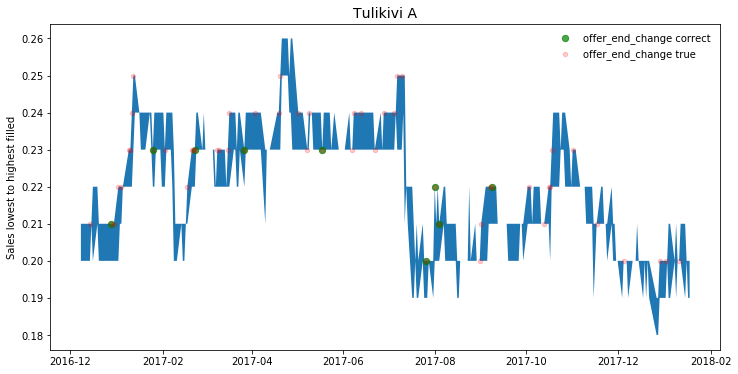

Tulikivi A   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 580 tasks      | elapsed:   25.2s
[Parallel(n_jobs=5)]: Done 901 tasks      | elapsed:   57.7s
[Parallel(n_jobs=5)]: Done 1251 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1701 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 2251 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 3125 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 4099 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.83      0.99      0.91       785
       rise       0.91      0.32      0.48       230

avg / total       0.85      0.84      0.81      1015

[[778   7]
 [156  74]]
Train roc_auc = 0.873

Test set classification
             precision    recall  f1-score   support

   not rise       0.84      0.96      0.90        56
       rise       0.67      0.29      0.40        14

avg / total       0.81      0.83      0.80        70

[[54  2]
 [10  4]]
Test roc_auc = 0.714

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 40}


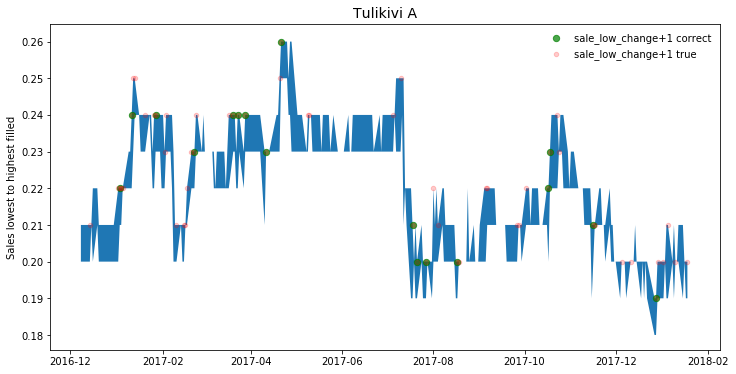

Tulikivi A   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 796 tasks      | elapsed:   47.5s
[Parallel(n_jobs=5)]: Done 1146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1819 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 2443 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 3242 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 4217 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.1min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.83      0.99      0.90       785
       rise       0.92      0.29      0.44       230

avg / total       0.85      0.83      0.80      1015

[[779   6]
 [163  67]]
Train roc_auc = 0.859

Test set classification
             precision    recall  f1-score   support

   not rise       0.87      0.93      0.90        56
       rise       0.60      0.43      0.50        14

avg / total       0.81      0.83      0.82        70

[[52  4]
 [ 8  6]]
Test roc_auc = 0.711

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 100, 'sel__k': 30}


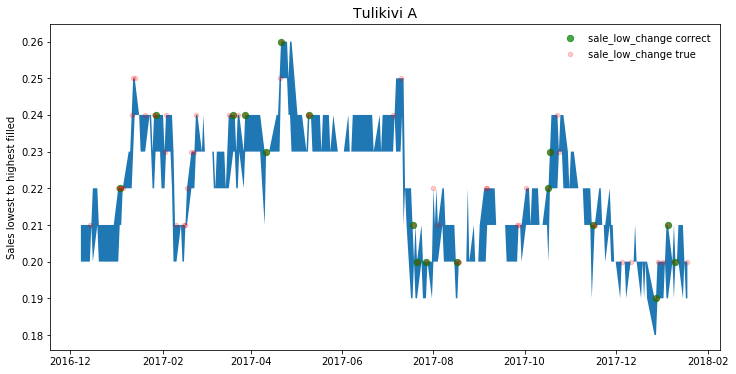

Tulikivi A   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 580 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done 902 tasks      | elapsed:   55.7s
[Parallel(n_jobs=5)]: Done 1252 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1925 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 2656 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 3397 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 4423 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  5.1min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       807
       rise       1.00      0.99      1.00       208

avg / total       1.00      1.00      1.00      1015

[[807   0]
 [  2 206]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.76      0.94      0.84        53
       rise       0.25      0.06      0.10        17

avg / total       0.63      0.73      0.66        70

[[50  3]
 [16  1]]
Test roc_auc = 0.371

{'gbm__learning_rate': 0.20000000000000001, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 100, 'sel__k': 40}


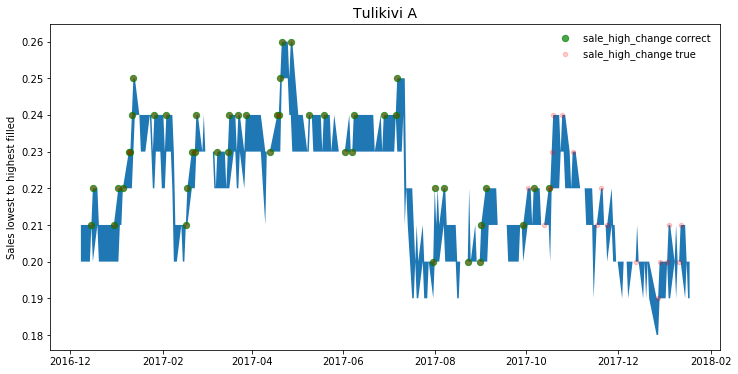

Valoe   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 808 tasks      | elapsed:   34.5s
[Parallel(n_jobs=5)]: Done 1200 tasks      | elapsed:   51.9s
[Parallel(n_jobs=5)]: Done 1930 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 2836 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 4136 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  3.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.93      1.00      0.96       915
       rise       0.91      0.30      0.45       100

avg / total       0.93      0.93      0.91      1015

[[912   3]
 [ 70  30]]
Train roc_auc = 0.857

Test set classification
             precision    recall  f1-score   support

   not rise       0.80      0.93      0.86        56
       rise       0.20      0.07      0.11        14

avg / total       0.68      0.76      0.71        70

[[52  4]
 [13  1]]
Test roc_auc = 0.608

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 40}


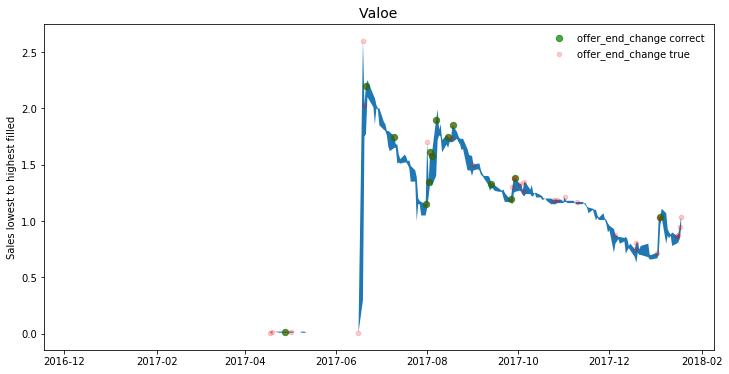

Valoe   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 582 tasks      | elapsed:   22.3s
[Parallel(n_jobs=5)]: Done 909 tasks      | elapsed:   46.6s
[Parallel(n_jobs=5)]: Done 1401 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 2027 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 2901 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 3970 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  4.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.94      1.00      0.97       924
       rise       1.00      0.41      0.58        91

avg / total       0.95      0.95      0.94      1015

[[924   0]
 [ 54  37]]
Train roc_auc = 0.913

Test set classification
             precision    recall  f1-score   support

   not rise       0.69      0.86      0.77        50
       rise       0.12      0.05      0.07        20

avg / total       0.53      0.63      0.57        70

[[43  7]
 [19  1]]
Test roc_auc = 0.543

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 10, 'gbm__n_estimators': 50, 'sel__k': 40}


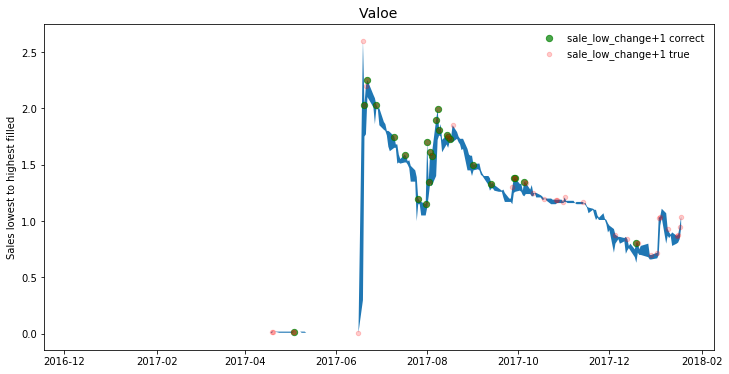

Valoe   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 584 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 912 tasks      | elapsed:   44.6s
[Parallel(n_jobs=5)]: Done 1409 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 2031 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 2906 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 3885 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  4.1min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.93      1.00      0.96       924
       rise       0.93      0.29      0.44        91

avg / total       0.93      0.93      0.92      1015

[[922   2]
 [ 65  26]]
Train roc_auc = 0.889

Test set classification
             precision    recall  f1-score   support

   not rise       0.73      0.90      0.80        50
       rise       0.38      0.15      0.21        20

avg / total       0.63      0.69      0.64        70

[[45  5]
 [17  3]]
Test roc_auc = 0.549

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 20}


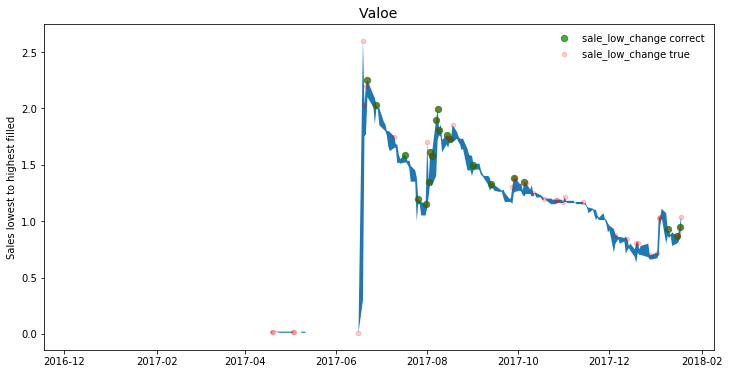

Valoe   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 592 tasks      | elapsed:   19.5s
[Parallel(n_jobs=5)]: Done 929 tasks      | elapsed:   37.6s
[Parallel(n_jobs=5)]: Done 1443 tasks      | elapsed:   54.6s
[Parallel(n_jobs=5)]: Done 2343 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 3443 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 4743 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 5031 out of 5040 | elapsed:  3.2min remaining:    0.3s
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  3.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.96      1.00      0.98       958
       rise       1.00      0.35      0.52        57

avg / total       0.96      0.96      0.96      1015

[[958   0]
 [ 37  20]]
Train roc_auc = 0.765

Test set classification
             precision    recall  f1-score   support

   not rise       0.81      0.95      0.87        55
       rise       0.50      0.20      0.29        15

avg / total       0.75      0.79      0.75        70

[[52  3]
 [12  3]]
Test roc_auc = 0.621

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 50, 'sel__k': 40}


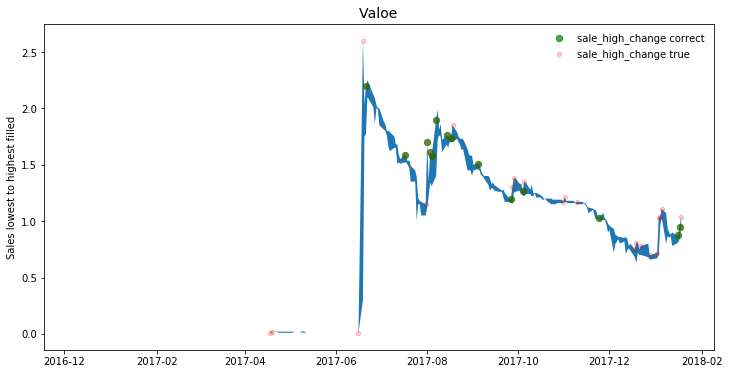

Ålandsbanken B   offer_end_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.4s
[Parallel(n_jobs=5)]: Done 640 tasks      | elapsed:   42.4s
[Parallel(n_jobs=5)]: Done 990 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1990 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 3390 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4240 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.3min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       538
       rise       1.00      1.00      1.00       477

avg / total       1.00      1.00      1.00      1015

[[538   0]
 [  0 477]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.61      0.62        41
       rise       0.47      0.48      0.47        29

avg / total       0.56      0.56      0.56        70

[[25 16]
 [15 14]]
Test roc_auc = 0.483

{'gbm__learning_rate': 0.15000000000000002, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 250, 'sel__k': 20}


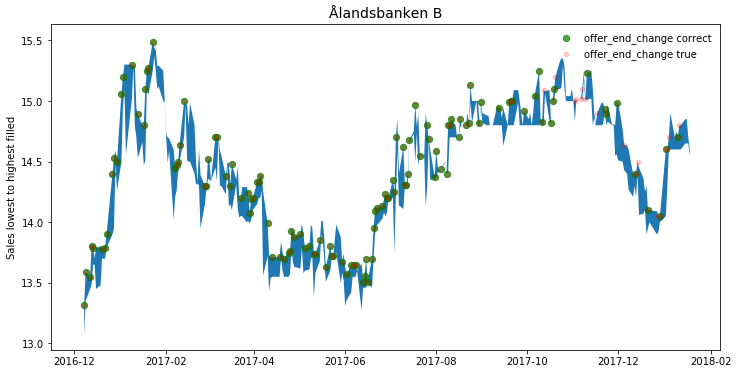

Ålandsbanken B   sale_low_change+1
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   41.7s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       547
       rise       1.00      1.00      1.00       468

avg / total       1.00      1.00      1.00      1015

[[547   0]
 [  0 468]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.67      0.75      0.71        44
       rise       0.48      0.38      0.43        26

avg / total       0.60      0.61      0.60        70

[[33 11]
 [16 10]]
Test roc_auc = 0.589

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 200, 'sel__k': 30}


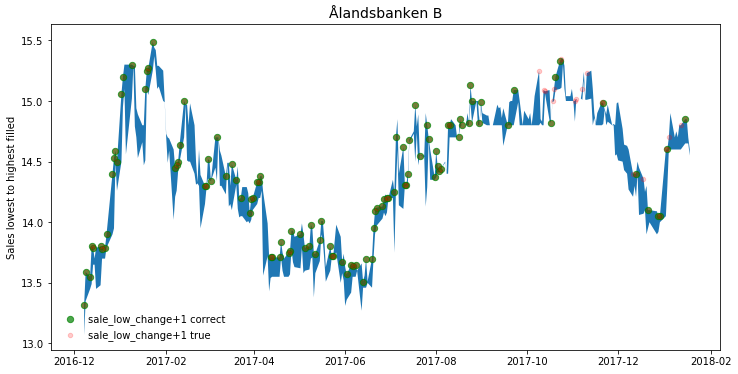

Ålandsbanken B   sale_low_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   41.7s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       547
       rise       1.00      1.00      1.00       468

avg / total       1.00      1.00      1.00      1015

[[547   0]
 [  0 468]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.69      0.77      0.73        44
       rise       0.52      0.42      0.47        26

avg / total       0.63      0.64      0.63        70

[[34 10]
 [15 11]]
Test roc_auc = 0.529

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 10, 'gbm__min_samples_leaf': 1, 'gbm__n_estimators': 300, 'sel__k': 40}


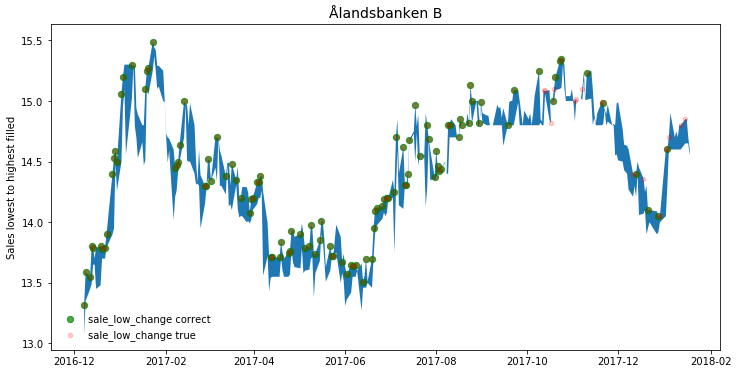

Ålandsbanken B   sale_high_change
Fitting 3 folds for each of 1680 candidates, totalling 5040 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   19.4s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:   42.8s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1992 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 2642 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 3392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 4242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 5040 out of 5040 | elapsed:  7.2min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.82      0.96      0.88       569
       rise       0.94      0.72      0.82       446

avg / total       0.87      0.86      0.85      1015

[[548  21]
 [124 322]]
Train roc_auc = 0.944

Test set classification
             precision    recall  f1-score   support

   not rise       0.57      0.69      0.62        42
       rise       0.32      0.21      0.26        28

avg / total       0.47      0.50      0.48        70

[[29 13]
 [22  6]]
Test roc_auc = 0.446

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__min_samples_leaf': 20, 'gbm__n_estimators': 50, 'sel__k': 40}


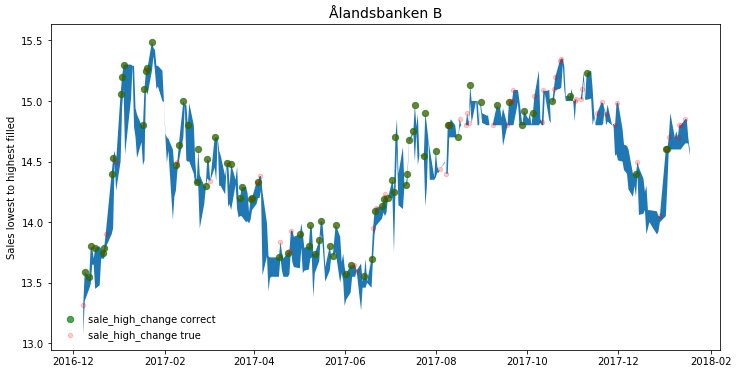

In [11]:
method_key = 'gbm'
print(companies)
results_dict = fit_and_report(companies, method_key, ntest = 70, show = True)

## Then test the obtained results:
### First make the prediction dataframe

In [35]:
# optimal parameters:
method_key = 'gbm'
opm_params = np.load('opm_params_{}.npy'.format(method_key)).item()


def get_predictions(ntest, comp, col):
    
    X, y, ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = opm_params[comp][col]['threshold'] < y[col]    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    
    pipe, _ = get_pipe(method_key)
    pipe.set_params(**opm_params[comp][col]['opm_params']) 
    pipe.fit(X_train, y_train)
    
    return pipe.predict(X_test)

def get_prediction_df(ntest):
    idx_tuples = [(comp, col) for comp in companies for col in y.columns]
    index = pd.MultiIndex.from_tuples(idx_tuples)
    
    
    pred_df = pd.DataFrame(index = comp_dict['Alma Media'][0].index[:ntest], columns = index)
    
    for comp in companies:
        ysim = comp_dict[comp][-1]

        for col in y.columns:
            pred_df[(comp, col)] = get_predictions(ntest, comp, col) #np.zeros(ntest)
        
        pred_df[(comp, 'sales_low_prev')] = ysim['sales_low_prev']
        pred_df[(comp, 'sales_high_prev')] = ysim['sales_high_prev']
        
        pred_df[(comp, 'sales_low_000'.format(nfut-1))] = ysim['sales_low_000'.format(nfut-1)]
        pred_df[(comp, 'sales_high_{:03d}'.format(nfut-1))] = ysim['sales_high_{:03d}'.format(nfut-1)]
        pred_df[(comp, 'offer_end_{:03d}'.format(nfut-1))] = ysim['offer_end_{:03d}'.format(nfut-1)]
    pred_df.index = comp_dict[comp][0].index.values[:ntest]
    return pred_df

df_pred = get_prediction_df(20) 


In [62]:
def simulate(pred_df, marginal = 1.5, roc_thres = .6, dealer = 0.):
    
    shop_df = pd.DataFrame(columns = ['index','day','comp','nstock', 'buy', 'sell'])
    shop_df.set_index(['index','day', 'comp'], inplace = True)
    
    # Defines the condition when stock is bought
    buy_condition = {'sale_low_change+1':False, 'sale_high_change':True} #
    free_money = 1e4
    action = False
    for i, day in enumerate(df_pred.index[::-1]):
        basket = []
        for comp in companies:
            if sim_ml:
                can_shop = False
                # Condition to buy:
                if all([pred_df.loc[day, comp][key] == val for key,val in buy_condition.items()]) and \
                    i+2 < len(df_pred):
                    # Make sure today sale low is smaller than yesterday:
                    if pred_df.loc[day, comp]['sales_low_000'] < pred_df.loc[day, comp]['sales_low_prev']:
                        buy_price = pred_df.loc[day, comp]['sales_low_prev']

                        if buy_price*(1+marginal/100.) \
                        < pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]: 
                            sell_price = buy_price*(1+marginal/100.)
                        else:
                            sell_price = pred_df.loc[day, comp]['offer_end_{:03d}'.format(nfut-1)]


                        can_shop = True
                if can_shop:
                    basket.append((comp, buy_price, sell_price))
            else:
                if (np.random.rand() < .05) & (i+2 < len(df_pred)):
                    buy_price = pred_df.loc[day, comp]['sales_low_prev']
                    if buy_price*(1+marginal/100.) \
                        < pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]: 
                            sell_price = buy_price*(1+marginal/100.)
                    else:
                        sell_price = pred_df.loc[day, comp]['offer_end_{:03d}'.format(nfut-1)]
                    basket.append((comp, buy_price, sell_price))
                    
        for scomp, buy, sell in basket:
            buy_roc = opm_params[scomp]['sale_low_change+1']['roc_auc']
            sell_roc = opm_params[scomp]['sale_high_change']['roc_auc']
            if (roc_thres < np.array([buy_roc, sell_roc])).all():
                n_stock = int(free_money/2/buy)
                free_money -= n_stock*buy  + dealer
                shop_df.loc[(i, day, scomp), ['nstock', 'buy', 'sell']] = n_stock, buy, sell 
                action = True
                print('Bought {} price={:.02f}'.format(scomp, buy))
        if action:
            # Time to sell:
            if i-1 in list(zip(*shop_df.index.values))[0]:
                for idx in [idx for idx in shop_df.index.values if idx[0] == i-1]:
                    n, price = shop_df.loc[idx][['nstock', 'sell']]
                    free_money += n*price - dealer
                    print('Sold {} price={:.02f}'.format(idx[2], price))
                print()
    print('Money in end: {:0f}'.format(free_money))
    return free_money

sim_ml = False
s = 0
for i in range(100):
    s += simulate(df_pred, 10, .6)
print(s/100)

Bought Caverion price=5.80
Bought Elisa price=32.69
Bought Ponsse price=26.55
Bought Sampo A price=45.42
Sold Caverion price=5.92
Sold Elisa price=32.71
Sold Ponsse price=26.43

Bought Scanfil price=4.14
Bought Telia Company price=3.72
Sold Sampo A price=45.80

Sold Scanfil price=4.35
Sold Telia Company price=3.73

Bought Citycon price=2.19
Bought Neste price=52.20
Bought Caverion price=6.22
Sold Citycon price=2.23
Sold Neste price=54.32

Bought Neste price=53.36
Sold Caverion price=6.20

Sold Neste price=56.46

Money in end: 10812.530000
Bought Technopolis price=3.98
Sold Technopolis price=4.15

Bought Kemira price=11.48
Bought Telia Company price=3.78
Sold Kemira price=11.91

Sold Telia Company price=3.92

Bought Citycon price=2.22
Bought Citycon price=2.21
Sold Citycon price=2.18

Sold Citycon price=2.17

Bought Elisa price=32.26
Bought Telia Company price=3.81
Bought Ponsse price=27.30
Sold Elisa price=32.14
Sold Telia Company price=3.82

Sold Ponsse price=26.65

Money in end: 1031

Bought Scanfil price=4.22
Bought Telia Company price=3.73
Sold Scanfil price=4.36
Sold Telia Company price=3.85

Bought Fiskars price=24.55
Bought Technopolis price=4.20
Sold Fiskars price=25.00
Sold Technopolis price=4.20

Bought Citycon price=2.16
Sold Citycon price=2.19

Money in end: 10539.960000
Bought Ponsse price=26.20
Bought Neste price=52.30
Sold Ponsse price=26.54

Bought Amer Sports A price=23.23
Sold Neste price=54.05

Bought Fiskars price=23.40
Sold Amer Sports A price=22.84

Sold Fiskars price=23.61

Bought Elisa price=32.60
Bought Amer Sports A price=22.74
Sold Elisa price=32.69

Bought Neste price=53.28
Sold Amer Sports A price=22.57

Sold Neste price=52.58

Bought Neste price=52.20
Sold Neste price=54.32

Bought Technopolis price=4.20
Sold Technopolis price=4.19

Money in end: 10250.670000
Bought Technopolis price=3.98
Bought Telia Company price=3.75
Sold Technopolis price=4.05

Bought Caverion price=5.92
Sold Telia Company price=3.74

Sold Caverion price=5.99

Bought 

Bought Sampo A price=45.47
Bought Telia Company price=3.70
Sold Sampo A price=45.77
Sold Telia Company price=3.75

Bought Ponsse price=27.50
Sold Ponsse price=28.40

Bought Sampo A price=46.78
Bought Technopolis price=4.19
Bought Technopolis price=4.15
Sold Sampo A price=46.91
Sold Technopolis price=4.13

Sold Technopolis price=4.20

Bought Apetit price=15.00
Bought Technopolis price=4.12
Sold Apetit price=15.10
Sold Technopolis price=4.23

Money in end: 10326.660000
Bought Neste price=51.30
Bought Sampo A price=45.67
Bought Apetit price=13.90
Bought Telia Company price=3.75
Sold Neste price=53.60
Sold Sampo A price=45.74

Sold Apetit price=14.00
Sold Telia Company price=3.74

Bought Ponsse price=26.16
Bought Neste price=53.25
Sold Ponsse price=27.55

Bought Kemira price=11.41
Sold Neste price=54.22

Bought Fiskars price=23.80
Bought Kemira price=11.44
Sold Kemira price=11.65

Bought Fiskars price=24.05
Sold Fiskars price=24.45
Sold Kemira price=11.60

Sold Fiskars price=24.75

Bought 

Bought Sampo A price=45.42
Bought Ponsse price=26.16
Bought Sampo A price=45.62
Sold Sampo A price=45.80

Sold Ponsse price=27.55
Sold Sampo A price=45.66

Bought Citycon price=2.17
Sold Citycon price=2.23

Bought Amer Sports A price=22.51
Bought Apetit price=14.70
Bought Scanfil price=4.32
Bought Neste price=53.36
Sold Amer Sports A price=22.93
Sold Apetit price=15.15
Sold Scanfil price=4.30

Sold Neste price=56.46

Bought Ponsse price=27.30
Bought Amer Sports A price=22.17
Sold Ponsse price=27.35

Sold Amer Sports A price=22.22

Money in end: 10433.450000
Bought Scanfil price=4.29
Bought Telia Company price=3.75
Bought Ponsse price=26.34
Sold Scanfil price=4.21
Sold Telia Company price=3.74

Sold Ponsse price=26.86

Bought Fiskars price=23.38
Bought Fiskars price=23.52
Sold Fiskars price=23.96

Bought Neste price=53.25
Sold Fiskars price=24.15

Bought Amer Sports A price=22.74
Bought Apetit price=14.05
Sold Neste price=54.22

Sold Amer Sports A price=22.57
Sold Apetit price=14.35

Bo

Bought Elisa price=32.66
Sold Amer Sports A price=22.60

Bought Fiskars price=24.20
Sold Elisa price=33.06

Sold Fiskars price=24.85

Bought Sampo A price=46.78
Bought Scanfil price=4.27
Sold Sampo A price=46.91

Sold Scanfil price=4.27

Bought Amer Sports A price=22.17
Sold Amer Sports A price=22.22

Money in end: 10365.700000
Bought Caverion price=5.92
Sold Caverion price=5.99

Bought Technopolis price=4.01
Sold Technopolis price=4.18

Bought Scanfil price=4.20
Sold Scanfil price=4.28

Bought Neste price=55.80
Bought Sampo A price=46.80
Sold Neste price=55.76

Sold Sampo A price=47.55

Money in end: 10407.590000
Bought Caverion price=5.92
Bought Fiskars price=23.40
Sold Caverion price=5.99

Sold Fiskars price=23.61

Bought Caverion price=5.85
Sold Caverion price=5.89

Bought Caverion price=5.93
Bought Ponsse price=27.20
Bought Scanfil price=4.22
Sold Caverion price=6.10

Bought Citycon price=2.17
Bought Kemira price=11.48
Sold Ponsse price=28.20
Sold Scanfil price=4.36

Bought Elisa 

Bought Neste price=54.00
Sold Kemira price=11.58

Sold Neste price=56.16

Bought Fiskars price=24.65
Bought Technopolis price=4.12
Sold Fiskars price=24.60
Sold Technopolis price=4.23

Money in end: 10073.160000
Bought Elisa price=32.43
Bought Ponsse price=26.32
Sold Elisa price=32.92
Sold Ponsse price=26.40

Bought Apetit price=13.95
Bought Amer Sports A price=22.82
Sold Apetit price=14.20

Sold Amer Sports A price=22.71

Bought Caverion price=6.10
Sold Caverion price=6.34

Bought Ponsse price=28.40
Sold Ponsse price=28.00

Bought Telia Company price=3.81
Bought Caverion price=6.32
Sold Telia Company price=3.82

Sold Caverion price=6.36

Money in end: 10317.870000
Bought Caverion price=5.98
Sold Caverion price=5.84

Bought Kemira price=11.37
Sold Kemira price=11.48

Bought Citycon price=2.12
Bought Kemira price=11.36
Bought Citycon price=2.14
Sold Citycon price=2.16
Sold Kemira price=11.47

Bought Amer Sports A price=22.74
Bought Caverion price=5.93
Bought Scanfil price=4.17
Sold City

Sold Sampo A price=46.67

Money in end: 10493.720000
Bought Amer Sports A price=22.50
Bought Citycon price=2.10
Sold Amer Sports A price=23.00
Sold Citycon price=2.13

Bought Apetit price=14.05
Bought Sampo A price=45.37
Bought Telia Company price=3.72
Bought Scanfil price=4.22
Sold Apetit price=14.35
Sold Sampo A price=46.06
Sold Telia Company price=3.78

Sold Scanfil price=4.36

Bought Kemira price=11.83
Bought Technopolis price=4.19
Sold Kemira price=11.58

Sold Technopolis price=4.13

Money in end: 10189.140000
Bought Citycon price=2.10
Bought Caverion price=5.80
Bought Neste price=53.15
Sold Citycon price=2.13

Sold Caverion price=5.92
Sold Neste price=54.05

Bought Ponsse price=27.20
Bought Fiskars price=24.05
Sold Ponsse price=28.20

Sold Fiskars price=24.75

Bought Elisa price=32.93
Sold Elisa price=32.36

Bought Elisa price=32.11
Bought Amer Sports A price=22.45
Sold Elisa price=32.01

Bought Amer Sports A price=22.17
Bought Sampo A price=46.80
Sold Amer Sports A price=22.18



Bought Scanfil price=4.27
Bought Technopolis price=4.15
Sold Scanfil price=4.27
Sold Technopolis price=4.20

Money in end: 10369.970000
Bought Apetit price=14.00
Bought Fiskars price=23.40
Sold Apetit price=14.08
Sold Fiskars price=23.61

Bought Neste price=53.40
Sold Neste price=53.35

Bought Sampo A price=45.51
Bought Scanfil price=4.20
Bought Scanfil price=4.17
Sold Sampo A price=45.58
Sold Scanfil price=4.28

Bought Kemira price=11.44
Sold Scanfil price=4.27

Bought Elisa price=32.66
Bought Fiskars price=24.05
Sold Kemira price=11.60

Sold Elisa price=33.06
Sold Fiskars price=24.75

Bought Technopolis price=4.20
Bought Kemira price=11.81
Sold Technopolis price=4.19

Sold Kemira price=11.68

Money in end: 10229.450000
Bought Elisa price=32.92
Bought Sampo A price=45.92
Bought Technopolis price=4.00
Sold Elisa price=32.96
Sold Sampo A price=45.81
Sold Technopolis price=4.04

Bought Scanfil price=4.03
Bought Telia Company price=3.72
Sold Scanfil price=4.25
Sold Telia Company price=3.7